# B.1.1.529 variant analysis

The B.1.1.529 (AKA omicron) has raised concerns due to its high number of mutations combining mutations from the alpha and delta lineages with new mutations.

Here we aim at understanding its potential impact in an escape from the immunity from the vaccine and from previous strains.

In [25]:
import os
import time
from multiprocessing import  Pool
import random
from itertools import cycle

from Bio import SeqIO, Align
from Bio.Seq import Seq, IUPAC
from Bio.Alphabet import ProteinAlphabet
from logzero import logger
import pandas as pd
import requests
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from upsetplot import UpSet
import dotenv
from neofox.neofox import NeoFox
from neofox.model.factories import NeoantigenFactory, PatientFactory
from neofox.references.references import ReferenceFolder
from neofox.model.conversion import ModelConverter

from scipy.stats import fisher_exact, iqr
from statsmodels.stats.multitest import multipletests

sns.set_style("whitegrid")
sns.set_context("notebook")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [2]:
figures_folder = "figures"
data_folder = "data"
resources_folder = "resources"
dpi = 600

## B.1.1.529 spike protein sequence

Unfortunately, we do not have access to GISAID now, but we have the list of omicron mutations in the spike protein from a reliable source, Pango designation repository.

From here https://github.com/cov-lineages/pango-designation/issues/343 we fetch the mutations in the spike protein. These are:

A67V, Δ69-70, T95I, G142D/Δ143-145, Δ211/L212I, ins214EPE, G339D, S371L, S373P, S375F, K417N, N440K, G446S, S477N, T478K, E484A, Q493K, G496S, Q498R, N501Y, Y505H, T547K, D614G, H655Y, N679K, P681H, N764K, D796Y, N856K, Q954H, N969K, L981F

We obtain the sequence of spike protein in the omicron lineage by applying these mutations to the reference genome.

In [3]:
reference_fasta = os.path.join(resources_folder, "Sars_cov_2.ASM985889v3.cds.all.fa")
spike_dna = None
for record in SeqIO.parse(reference_fasta, "fasta"):
    if "gene_symbol:S" in record.description:
        spike_dna = record
print(spike_dna.seq)

ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAA

In [4]:
spike_protein = spike_dna.translate()
print(spike_protein.seq)

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGR

In [5]:
def apply_mutation(sequence, position, reference, alternate):
    logger.info("Applying mutation {}:{}>{}".format(position, reference, alternate))
    if len(reference) == 1 and len(alternate) == 1:
        ## SNV
        assert reference == sequence[position - 1], "Not matching to reference"
        return sequence[0:position - 1] + alternate + sequence[position:], 0
    if len(alternate) == 0:
        ## deletion
        assert reference == str(sequence[position - 1: position - 1 + len(reference)].seq), "Not matching to reference: {}".format(
            str(sequence[position - 1: position - 1 + len(reference)].seq))
        return sequence[0:position - 1] + alternate + sequence[position + len(reference) - 1 : ], - len(reference)
    if len(reference) == 0:
        ## insertion
        return sequence[0:position - 1] + alternate + sequence[position - 1 : ], len(alternate)

def apply_mutations(protein, mutations):
    offset = 0
    for p, r, a in mutations:
        protein, mutation_offset = apply_mutation(protein, position=p + offset, reference=r, alternate=a)
        offset = offset + mutation_offset
    return protein

In [6]:
omicron_mutations = [
    (67, "A", "V"),             #A67V
    (69, "HV", ""),             #Δ69-70, 
    (95, "T", "I"),             #T95I, 
    (142, "G", "D"),            #G142D
    (143, "VYY", ""),           #Δ143-145, 
    (211, "N", ""),             #Δ211
    (212, "L", "I"),            #L212I, 
    (214, "", "EPE"),           #ins214EPE, 
    (339, "G", "D"),            #G339D, 
    (371, "S", "L"),            #S371L, 
    (373, "S", "P"),            #S373P, 
    (375, "S", "F"),            #S375F, 
    (417, "K", "N"),            #K417N, 
    (440, "N", "K"),            #N440K, 
    (446, "G", "S"),            #G446S, 
    (477, "S", "N"),            #S477N, 
    (478, "T", "K"),            #T478K, 
    (484, "E", "A"),            #E484A, 
    (493, "Q", "R"),            #Q493R, 
    (496, "G", "S"),            #G496S, 
    (498, "Q", "R"),            #Q498R, 
    (501, "N", "Y"),            #N501Y, 
    (505, "Y", "H"),            #Y505H, 
    (547, "T", "K"),            #T547K, 
    (614, "D", "G"),            #D614G, 
    (655, "H", "Y"),            #H655Y,
    (679, "N", "K"),            #N679K, 
    (681, "P", "H"),            #P681H, 
    (764, "N", "K"),            #N764K, 
    (796, "D", "Y"),            #D796Y, 
    (856, "N", "K"),            #N856K, 
    (954, "Q", "H"),            #Q954H, 
    (969, "N", "K"),            #N969K, 
    (981, "L", "F")             #L981F
]

omicron_apike_protein = apply_mutations(protein=spike_protein, mutations=omicron_mutations)
print(omicron_apike_protein.seq)

[I 220105 10:05:50 4276497315:2] Applying mutation 67:A>V
[I 220105 10:05:50 4276497315:2] Applying mutation 69:HV>
[I 220105 10:05:50 4276497315:2] Applying mutation 93:T>I
[I 220105 10:05:50 4276497315:2] Applying mutation 140:G>D
[I 220105 10:05:50 4276497315:2] Applying mutation 141:VYY>
[I 220105 10:05:50 4276497315:2] Applying mutation 206:N>
[I 220105 10:05:50 4276497315:2] Applying mutation 206:L>I
[I 220105 10:05:50 4276497315:2] Applying mutation 208:>EPE
[I 220105 10:05:50 4276497315:2] Applying mutation 336:G>D
[I 220105 10:05:50 4276497315:2] Applying mutation 368:S>L
[I 220105 10:05:50 4276497315:2] Applying mutation 370:S>P
[I 220105 10:05:50 4276497315:2] Applying mutation 372:S>F
[I 220105 10:05:50 4276497315:2] Applying mutation 414:K>N
[I 220105 10:05:50 4276497315:2] Applying mutation 437:N>K
[I 220105 10:05:50 4276497315:2] Applying mutation 443:G>S
[I 220105 10:05:50 4276497315:2] Applying mutation 474:S>N
[I 220105 10:05:50 4276497315:2] Applying mutation 475:T>K

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHVISGTNGTKRFDNPVLPFNDGVYFASIEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPIIVEPERDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLKGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFKGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNHNAQALNTLVKQLSSKFGAISSVLNDIFSRLDKVEAEVQIDRLITGRLQS

## B.1.617.2 (delta) spike protein sequence

We obtain the spike mutations in the B.1.617.2 lineage from here: https://github.com/cov-lineages/constellations/blob/main/constellations/definitions/cB.1.617.2.json

These are:
T19R, G142D, L452R, T478K, P681R, D950N

We need to add in the mutation D614G shared by alpha, beta, gamma, delta and omicron.

Also, from above the deletion 22028:GAGTTCA>G is missing. This translates at the aminoacid level in two mutations E156G and Δ157-158

In [7]:
delta_mutations = [
    (19, "T", "R"),            # T19R
    (142, "G", "D"),           # G142D
    (156, "E", "G"),           # E156G
    (157, "FR", ""),           # Δ157-158
    (452, "L", "R"),           # L452R 
    (478, "T", "K"),           # T478K
    (614, "D", "G"),           # T478K
    (681, "P", "R"),           # P681R 
    (950, "D", "N")            # D950N
]

delta_spike_protein = apply_mutations(protein=spike_protein, mutations=delta_mutations)
print(delta_spike_protein.seq)

[I 220105 10:05:54 4276497315:2] Applying mutation 19:T>R
[I 220105 10:05:54 4276497315:2] Applying mutation 142:G>D
[I 220105 10:05:54 4276497315:2] Applying mutation 156:E>G
[I 220105 10:05:54 4276497315:2] Applying mutation 157:FR>
[I 220105 10:05:54 4276497315:2] Applying mutation 450:L>R
[I 220105 10:05:54 4276497315:2] Applying mutation 476:T>K
[I 220105 10:05:54 4276497315:2] Applying mutation 612:D>G
[I 220105 10:05:54 4276497315:2] Applying mutation 679:P>R
[I 220105 10:05:54 4276497315:2] Applying mutation 948:D>N


MFVFLVLLPLVSSQCVNLRTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDVYYHKNNKSWMESGVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQNVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQ

## Epitopes

Given the two spike protein sequences we aim at understanding how the set of epitopes from each of these proteins may be recognised differently by the immune system.

We download from IEDB 1502 linear epitopes from SARS-CoV-2 spike glycoprotein with positive outcome for T-cell or MHC binding on 26/11/2021. Of these only 1500 have an exact match with the reference; but only 1437 have an exact match with the B.1.1.529 spike protein. For the remaining 64 epitopes without an exact match in B.1.1.529 we perform a global alignment and fetch the closest sequences.

### Identify epitopes of interest

We are interested in the epitopes that do not have an exact match in omicron, in delta or in both.

For Omicron the epitopes of interest are those not having a exact match, ie: 275 + 121 + 1; while for Delta this corresponds to 121 + 48 + 1.

There are two epitopes without a match in the reference genome http://www.iedb.org/epitope/1597230 and http://www.iedb.org/epitope/1597243. The missing epitope with a match in the Omicron sequence overlaps the mutation K417N which is also observed in the Beta lineage.

!["figures/omicron_iedb_venn.drawio.png"](figures/omicron_iedb_venn.drawio.png)

In [8]:
epitopes = pd.read_csv(os.path.join(resources_folder, "epitope_table_export_1641363417.csv"), sep=",", skiprows=1)
epitopes = epitopes[epitopes["Object Type"] == "Linear peptide"]
epitopes["epitope"] = epitopes.Description.transform(lambda e: e.split(" ")[0])
epitopes.head()

,Epitope ID,Object Type,Description,Epitope Modified Residue(s),Epitope Modification(s),Starting Position,Ending Position,Non-peptidic epitope Accession,Epitope Synonyms,Antigen Name,...,Description.1,Starting Position.1,Ending Position.1,Non-peptidic object Accession,Synonyms,Antigen Name.1,Parent Protein.1,Organism Name.1,Parent Organism.1,epitope
0,1220,Linear peptide,AEVQIDRLI,NaN,NaN,989.0,997.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AEVQIDRLI
1,2801,Linear peptide,ALNTLVKQL,NaN,NaN,958.0,966.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALNTLVKQL
2,3589,Linear peptide,APHGVVFLHV,NaN,NaN,1056.0,1065.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APHGVVFLHV
3,4321,Linear peptide,ASANLAATK,NaN,NaN,1020.0,1028.0,NaN,NaN,Spike glycoprotein,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ASANLAATK
4,6668,Linear peptide,CMTSCCSCLK,NaN,NaN,1236.0,1245.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CMTSCCSCLK


In [9]:
epitopes.shape

(411, 29)

In [48]:
def get_alignment(sequence, epitope):
    alignment = None
    aligner = Align.PairwiseAligner()
    aligner.mode = 'global'
    aligner.match = 2
    aligner.mismatch = -2
    aligner.open_gap_score = -3
    aligner.extend_gap_score = -1
    aligner.target_end_gap_score = 0.0
    aligner.query_end_gap_score = 0.0
    try:
        alignment = aligner.align(sequence, epitope)
    except ValueError as e:
        logger.error(epitope)
        logger.error(e)
    return alignment

def has_exact_match(sequence, epitope):
    exact_match = False
    alignments = get_alignment(sequence=sequence, epitope=epitope)
    if alignments is not None:
        alignment = alignments[0]
        exact_match = len(alignment.aligned[1]) == 1 and alignment.query == alignment.target[alignment.aligned[0][0][0] : alignment.aligned[0][0][1]]
    return exact_match

In [49]:
# calculates the exact match for every epitope on each of the spike proteins
epitopes["has_exact_match_reference"] = epitopes.epitope.transform(lambda e: has_exact_match(sequence=spike_protein.seq[0:-1], epitope=e))
epitopes["has_exact_match_omicron"] = epitopes.epitope.transform(lambda e: has_exact_match(sequence=omicron_apike_protein.seq[0:-1], epitope=e))
epitopes["has_exact_match_delta"] = epitopes.epitope.transform(lambda e: has_exact_match(sequence=delta_spike_protein.seq[0:-1], epitope=e))

In [50]:
epitopes.has_exact_match_reference.sum()

398

In [51]:
epitopes.has_exact_match_omicron.sum()

321

In [52]:
epitopes.has_exact_match_delta.sum()

368

In [53]:
omicron_epitopes = epitopes[(~epitopes.has_exact_match_omicron) & (epitopes.has_exact_match_reference)]
omicron_epitopes.shape

(78, 35)

In [54]:
delta_epitopes = epitopes[(~epitopes.has_exact_match_delta) & (epitopes.has_exact_match_reference)]
delta_epitopes.shape

(31, 35)

In [55]:
omicron_and_delta_epitopes = epitopes[(~epitopes.has_exact_match_omicron) & (~epitopes.has_exact_match_delta) & (epitopes.has_exact_match_reference)]
omicron_and_delta_epitopes.shape

(21, 35)

In [56]:
unique_omicron_epitopes = epitopes[(epitopes.has_exact_match_omicron) & (~epitopes.has_exact_match_reference)]
unique_omicron_epitopes.shape

(1, 35)

In [57]:
unique_delta_epitopes = epitopes[(epitopes.has_exact_match_delta) & (~epitopes.has_exact_match_reference)]
unique_delta_epitopes.shape

(1, 35)

In [41]:
def plot_upset(data, figname=None, title=""):
    data.rename(columns={"has_exact_match_reference": "Wuhan strain", 
                         "has_exact_match_delta": "Delta",
                         "has_exact_match_omicron": "Omicron"}, inplace=True)
    data = data[["Wuhan strain", "Omicron", "Delta", "Epitope ID"]].groupby(
        ["Wuhan strain", "Omicron", "Delta"]).count()["Epitope ID"]
    
    #return data
    fig = plt.figure(figsize=(10,6))
    upset = UpSet(data, subset_size='auto', intersection_plot_elements=2, facecolor='steelblue', 
                  show_counts=True, element_size=80, orientation='horizontal')
    upset.plot(fig=fig)
    plt.title(title)
    if figname:
        fig.savefig(os.path.join(figures_folder, figname), dpi=dpi)

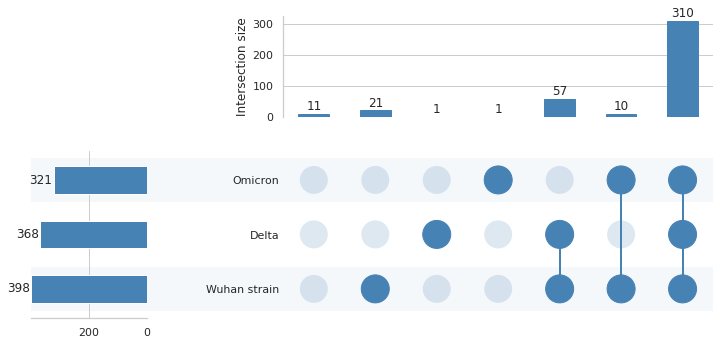

In [42]:
plot_upset(data=epitopes, figname="figure_00_epitopes_upset.png", title="")

### Find homologous epitopes

In [58]:
# finds the closest match to epitope in the provided sequence
def get_closest_match(sequence, epitope):
    alignments = get_alignment(sequence=sequence, epitope=epitope)
    if alignments is not None:
        alignment = alignments[0]
        start, _ = min(alignment.aligned[0])
        _, end = max(alignment.aligned[0])
    return str(sequence[start:end])

In [59]:
omicron_epitopes["homologous_epitope"] = omicron_epitopes.epitope.transform(lambda e: get_closest_match(sequence=omicron_apike_protein.seq[0:-1], epitope=e))
# filter out epitopes smaller than 8 AAs
omicron_epitopes = omicron_epitopes[(omicron_epitopes.epitope.transform(len) >= 8) & (omicron_epitopes.homologous_epitope.transform(len) >= 8)]
omicron_epitopes[["epitope", "homologous_epitope"]].head()

,epitope,homologous_epitope
8,GSFCTQLNR,GSFCTQLKR
26,SVLNDILSR,SVLNDIFSR
28,VLNDILSRL,VLNDIFSRL
31,NGVEGFNCYFPLQSY,NGVAGFNCYFPLRSY
35,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVAS,AGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVAS


In [60]:
delta_epitopes["homologous_epitope"] = delta_epitopes.epitope.transform(lambda e: get_closest_match(sequence=delta_spike_protein.seq[0:-1], epitope=e))
# filter out epitopes smaller than 8 AAs
delta_epitopes = delta_epitopes[(delta_epitopes.epitope.transform(len) >= 8) & (delta_epitopes.homologous_epitope.transform(len) >= 8)]
delta_epitopes[["epitope", "homologous_epitope"]].head()

,epitope,homologous_epitope
32,YLYRLFRKSNLKPFE,YRYRLFRKSNLKPFE
35,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVAS,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVAS
47,FCNDPFLGVYY,FCNDPFLDVYY
69,KSWMESEFRVY,KSWMESGVY
71,KVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYV,KVCEFQFCNDPFLDVYYHKNNKSWMESGVYSSANNCTFEYV


In [61]:
omicron_and_delta_epitopes["homologous_epitope_omicron"] = omicron_and_delta_epitopes.epitope.transform(
    lambda e: get_closest_match(sequence=omicron_apike_protein.seq[0:-1], epitope=e))
omicron_and_delta_epitopes["homologous_epitope_delta"] = omicron_and_delta_epitopes.epitope.transform(
    lambda e: get_closest_match(sequence=delta_spike_protein.seq[0:-1], epitope=e))
omicron_and_delta_epitopes[["epitope", "homologous_epitope_omicron", "homologous_epitope_delta"]].head()

,epitope,homologous_epitope_omicron,homologous_epitope_delta
35,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVAS,AGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVAS,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVAS
47,FCNDPFLGVYY,FCNDPFL,FCNDPFLDVYY
71,KVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYV,KVCEFQFCNDPFLDHKNNKSWMESEFRVYSSANNCTFEYV,KVCEFQFCNDPFLDVYYHKNNKSWMESGVYSSANNCTFEYV
76,LPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERD,LPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERD,LPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERD
98,SYQTQTNSPRRARSVA,SYQTQTKSHRRARSVA,SYQTQTNSRRRARSVA


In [62]:
omicron_and_delta_epitopes[omicron_and_delta_epitopes.homologous_epitope_delta == omicron_and_delta_epitopes.homologous_epitope_omicron].shape

(3, 37)

In [63]:
omicron_and_delta_epitopes[omicron_and_delta_epitopes.homologous_epitope_delta != omicron_and_delta_epitopes.homologous_epitope_omicron].shape

(18, 37)

In [64]:
unique_delta_epitopes["homologous_epitope"] = unique_delta_epitopes.epitope.transform(lambda e: get_closest_match(sequence=delta_spike_protein.seq[0:-1], epitope=e))
unique_omicron_epitopes["homologous_epitope"] = unique_omicron_epitopes.epitope.transform(lambda e: get_closest_match(sequence=omicron_apike_protein.seq[0:-1], epitope=e))

### Coverage


In [65]:
len(spike_protein)

1274

In [66]:
epitopes.epitope.head()

0     AEVQIDRLI
1     ALNTLVKQL
2    APHGVVFLHV
3     ASANLAATK
4    CMTSCCSCLK
Name: epitope, dtype: object

In [67]:
coverage_spike_protein = {p: 0 for p in range(len(spike_protein))}
for e in epitopes.epitope:
    alignments = get_alignment(sequence=spike_protein.seq[0:-1], epitope=str(e))
    if alignments is not None:
        alignment = alignments[0]
        start, _ = min(alignment.aligned[0])
        _, end = max(alignment.aligned[0])
        for p in range(start, end):
            coverage_spike_protein[p] = coverage_spike_protein[p] + 1

In [68]:
coverage_df = pd.DataFrame.from_dict(coverage_spike_protein, orient="index", columns=["coverage"]).reset_index().rename(columns={"index": "position"})
coverage_df.head()

,position,coverage
0,0,0
1,1,2
2,2,2
3,3,2
4,4,2


In [176]:
gaps = coverage_df[coverage_df.coverage == 0]
gaps["position_shift"] = gaps.position - gaps.position.shift(1)
index = 0
def label_gaps(x):
    global index
    if x != 1:
        index += 1
    return index
gaps["gap"] = gaps.position_shift.transform(label_gaps)
pd.DataFrame({
    "start": gaps[["position", "gap"]].groupby("gap").first().reset_index().position,
    "length": gaps[["position", "gap"]].groupby("gap").count().reset_index().position
})

,start,length
0,0,1
1,180,5
2,282,8
3,541,9
4,567,6
5,597,5
6,770,7
7,966,8
8,1033,3
9,1110,3


In [70]:
def plot_coverage(data, figname, title):
    
    fig = plt.figure(figsize=(16,6))
    #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 8), gridspec_kw={'height_ratios': [4, 1, 1]})
    data["color"] = "something"
    g = sns.lineplot(data=data, x="position", y="coverage", legend=False, hue="color", palette=[sns.color_palette("colorblind")[7]])
         
    # draw domains
    g.axes.axvspan(33, 337, alpha=0.2, color=sns.color_palette("colorblind")[0])
    plt.text(33 + 10, 0, "S1-N", horizontalalignment='left', size='small', color='black')
    g.axes.axvspan(349, 526, alpha=0.2, color=sns.color_palette("colorblind")[1])
    plt.text(349 + 10, 0, "RBD", horizontalalignment='left', size='small', color='black')
    g.axes.axvspan(536, 592, alpha=0.2, color=sns.color_palette("colorblind")[2])
    plt.text(536 + 10, 0, "S1-C", horizontalalignment='left', size='small', color='black')
    g.axes.axvspan(711, 1232, alpha=0.2, color=sns.color_palette("colorblind")[3])
    plt.text(711 + 10, 0, "S2", horizontalalignment='left', size='small', color='black')
    
    # set labels
    plt.title(title, size=20)
    plt.xlabel("amino acid position in spike protein")
    plt.ylabel("Epitope coverage")
    sns.despine(bottom=True, left=True)
    
    delta_mutations_df = pd.DataFrame({'position':[m[0] for m in delta_mutations], 'strain':["B.1.627.2" for m in delta_mutations]})
    omicron_mutations_df = pd.DataFrame({'position':[m[0] for m in omicron_mutations], 'strain':["B.1.1.529" for m in omicron_mutations]})
    
    #sns.rugplot(x=[m[0] for m in omicron_mutations], height=.2)
    sns.rugplot(data=pd.concat([delta_mutations_df, omicron_mutations_df]).reset_index(), x="position", hue="strain", height=.2, 
                legend=True, palette=[sns.color_palette("colorblind")[9], sns.color_palette("colorblind")[6]])
    
    #plt.legend(title="")
    
    fig.savefig(os.path.join(figures_folder, figname), dpi=dpi)

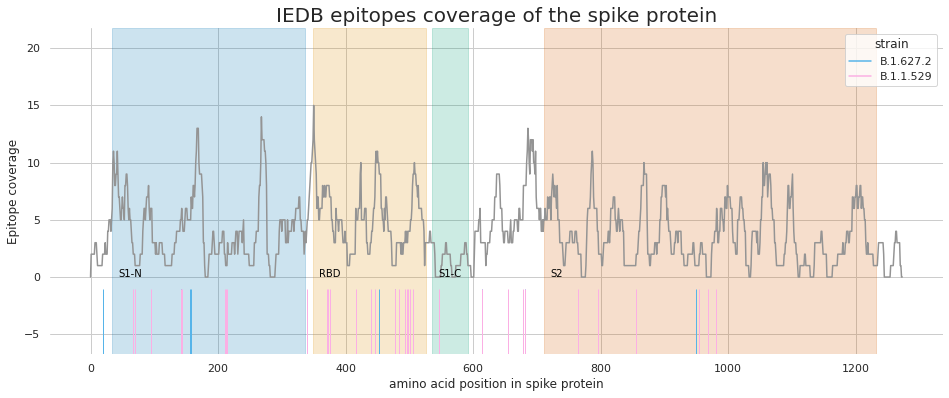

In [71]:
plot_coverage(data=coverage_df, figname="figure_00_epitopes_coverage.png", title="IEDB epitopes coverage of the spike protein")

## Overlapping mutations

In [72]:
def get_overlapping_mutations_for_epitope(sequence, epitope, mutations):
    alignments = get_alignment(sequence=sequence, epitope=epitope)
    if alignments is not None:
        alignment = alignments[0]
        start, _ = min(alignment.aligned[0])
        _, end = max(alignment.aligned[0])
    return list(map(lambda m: "{}{}{}".format(m[1], m[0], m[2]), filter(lambda x: x[0] >= start and x[0] <= end, mutations)))

def get_overlapping_mutations(sequence, epitopes, mutations):
    epitopes["overlapping_mutations"] = epitopes.epitope.transform(
        lambda e: get_overlapping_mutations_for_epitope(sequence=sequence.seq[0:-1], epitope=e, mutations=mutations))
    epitopes_overlapping_mutations = epitopes[["epitope", "homologous_epitope", "overlapping_mutations"]].set_index(
        ["epitope", "homologous_epitope"])['overlapping_mutations'].apply(pd.Series).stack()
    epitopes_overlapping_mutations = epitopes_overlapping_mutations.reset_index()
    del epitopes_overlapping_mutations["level_2"]
    epitopes_overlapping_mutations.rename(columns={0: "mutation"}, inplace=True)
    epitopes_overlapping_mutations.drop_duplicates(inplace=True)
    return epitopes_overlapping_mutations

In [73]:
omicron_overlapping_mutations = get_overlapping_mutations(
    sequence=spike_protein, epitopes=omicron_epitopes, mutations=omicron_mutations)
omicron_overlapping_mutations.head()

,epitope,homologous_epitope,mutation
0,GSFCTQLNR,GSFCTQLKR,N764K
1,SVLNDILSR,SVLNDIFSR,L981F
2,VLNDILSRL,VLNDIFSRL,L981F
3,NGVEGFNCYFPLQSY,NGVAGFNCYFPLRSY,E484A
4,NGVEGFNCYFPLQSY,NGVAGFNCYFPLRSY,Q493R


In [74]:
omicron_overlapping_counts = omicron_overlapping_mutations[["mutation", "epitope"]]\
    .groupby("mutation").count().sort_values("epitope", ascending=False).reset_index()
omicron_overlapping_counts.to_csv(os.path.join(data_folder, "table_01_omicron_mutation_counts.csv"), index=False)
omicron_overlapping_counts

,mutation,epitope
0,S371L,9
1,S375F,8
2,S373P,8
3,P681H,8
4,N679K,8
5,Y505H,6
6,T95I,6
7,G446S,6
8,L981F,4
9,Q498R,4


In [75]:
delta_overlapping_mutations = get_overlapping_mutations(
    sequence=spike_protein, epitopes=delta_epitopes, mutations=delta_mutations)

In [76]:
delta_overlapping_counts = delta_overlapping_mutations[["mutation", "epitope"]]\
    .groupby("mutation").count().sort_values("epitope", ascending=False).reset_index()
delta_overlapping_counts.to_csv(os.path.join(data_folder, "table_01_delta_mutation_counts.csv"), index=False)
delta_overlapping_counts

,mutation,epitope
0,L452R,9
1,P681R,8
2,E156G,4
3,FR157,4
4,G142D,4
5,D614G,3
6,D950N,1
7,T19R,1
8,T478K,1


In [77]:
unique_omicron_overlapping_mutations = get_overlapping_mutations(
    sequence=spike_protein, epitopes=unique_omicron_epitopes, mutations=omicron_mutations)
unique_omicron_overlapping_mutations.head()

,epitope,homologous_epitope,mutation
0,NIADYNYKL,NIADYNYKL,K417N


In [78]:
unique_delta_overlapping_mutations = get_overlapping_mutations(
    sequence=spike_protein, epitopes=unique_delta_epitopes, mutations=delta_mutations)
unique_delta_overlapping_mutations.head()

,epitope,homologous_epitope,mutation
0,NYNYRYRLF,NYNYRYRLF,L452R


## HLA alleles

We select the top 5 HLA alleles from some selected populations from the resource http://www.allelefrequencies.net.

We fetch data from the following populations:
* Europe
* Sub-Saharan Africa
* Black in South Africa (n=142) (http://www.allelefrequencies.net/pop6001c.asp?pop_name=South%20African%20%20Black)
* White in South Africa (n=102) (http://www.allelefrequencies.net/pop6001c.asp?pop_name=South%20Africa%20Caucasians)
* Zulu in South Africa (n=100, only HLA-A and HLA-B) (http://www.allelefrequencies.net/pop6001c.asp?pop_name=South%20Africa%20Natal%20Zulu)

In [79]:
top5_european_hla_alleles = [
    "HLA-A*01:01",
    "HLA-A*02:01",
    "HLA-A*03:01",
    "HLA-A*11:01",
    "HLA-A*24:02",
    "HLA-B*07:02",
    "HLA-B*51:01",
    "HLA-B*08:01",
    "HLA-B*44:02",
    "HLA-B*35:01",
    "HLA-C*07:01",
    "HLA-C*04:01",
    "HLA-C*07:02",
    "HLA-C*06:02",
    "HLA-C*05:01"
]

In [80]:
top5_subsaharan_hla_alleles = [
    "HLA-A*23:01",
    "HLA-A*02:01",
    "HLA-A*30:02",
    "HLA-A*74:01",
    "HLA-A*68:02",
    "HLA-B*07:02",
    "HLA-B*08:02",
    "HLA-B*08:01",
    "HLA-B*08:03",
    "HLA-B*07:05",
    "HLA-C*06:02",
    "HLA-C*04:01",
    "HLA-C*07:01",
    "HLA-C*02:02",
    "HLA-C*17:01"
]

In [81]:
top5_south_africa_black_hla_alleles = [
    "HLA-A*30:02",
    "HLA-A*30:01",
    "HLA-A*68:02",
    "HLA-A*03:01",
    "HLA-A*29:02",
    "HLA-B*58:02",
    "HLA-B*45:01",
    "HLA-B*15:10",
    "HLA-B*15:03",
    "HLA-B*42:01",
    "HLA-C*06:02",
    "HLA-C*04:01",
    "HLA-C*17:01",
    "HLA-C*02:10",
    "HLA-C*16:01"
]

In [82]:
top5_south_africa_white_hla_alleles = [
    "HLA-A*02:01",
    "HLA-A*01:01",
    "HLA-A*03:01",
    "HLA-A*24:02",
    "HLA-A*11:01",
    "HLA-B*07:02",
    "HLA-B*08:01",
    "HLA-B*15:01",
    "HLA-B*35:01",
    "HLA-B*44:02",
    "HLA-C*07:01",
    "HLA-C*07:02",
    "HLA-C*04:01",
    "HLA-C*06:02",
    "HLA-C*02:02"
]

In [83]:
top5_south_africa_zulu_hla_alleles = [
    "HLA-A*29:02",
    "HLA-A*23:01",
    "HLA-A*68:02",
    "HLA-A*30:01",
    "HLA-A*30:02",
    "HLA-B*42:01",
    "HLA-B*44:03",
    "HLA-B*15:03",
    "HLA-B*58:02",
    "HLA-B*15:10"
]

## Differential MHC I binding

Using NetMHCpan through IEDB tools we calculate the differential MHC binding between epitopes present in the reference spike protein and epitopes in B.1.1.529.

We use the top 5 HLA alleles in Europe fetched from http://www.allelefrequencies.net/top10freqsc.asp.

### Compute MHC binding predictions on the epitopes of interest and their homologous epitopes

We use netMHCpan 4.1 to obtain the MHC binding predicted ranks on the WT epitopes of interest and their homologous counterparts on omicron and delta strains.

In [84]:
#session = requests.Session()

#def get_best_rank_mhc_binding(epitope, hla_allele='HLA-A*01:01', length=9):
#    retries = 0
#    success = False
#    while not success and retries <= 5:
#        response = session.post("http://tools-cluster-interface.iedb.org/tools_api/mhci/", 
#                                 data = {'method':'netmhcpan-4.1', 'sequence_text':epitope, 'allele':hla_allele,'length':length})
#        retries += 1
#        success = response.status_code == 200
#        if not success:
#            #N = (2 ** retries) - 1
#            #t = (1 / (N + 1)) * sum(range(N + 1))
#            #time.sleep(random.uniform(0, t))
#            #time.sleep(random.uniform(1, 2))
#            time.sleep(2)
#    if not success:
#        logger.info("Retries exhausted for {} on {}".format(epitope, hla_allele))
#    if success:
#        binding_results = pd.read_csv(StringIO(response.text), sep="\t")
#        #binding_results.to_csv("netmhcpan_results/{}_{}.csv".format(epitope, hla_allele.replace("*", "_").replace(":", "_")), index=False)
#        if "percentile_rank" in binding_results.columns:
#            return float(binding_results.percentile_rank.iloc[0]) ##, binding_results.peptide.iloc[0]
#    return None

In [85]:
import tempfile
import subprocess
netmhcpan = "/home/priesgo/neofox_install/netMHCpan-4.1/netMHCpan"

def get_best_rank_mhc_binding(epitope, hla_allele='HLA-A*01:01', length=9):
    
    rank = None   
    tmp = tempfile.NamedTemporaryFile()

    # Open the file for writing.
    with open(tmp.name, 'w') as f:
        f.write(epitope)
    # -BA
    command = "{netmhcpan} -p {fasta} -a {hla_allele} -s".format(
        netmhcpan=netmhcpan, fasta=tmp.name, hla_allele=hla_allele.replace("*", ""), epitope=epitope)
    
    process = subprocess.Popen(
            command.split(" "),
            stderr=subprocess.PIPE,
            stdout=subprocess.PIPE
        )
    output, errors = process.communicate()
    return_code = process.returncode
    for l in output.decode("utf8").split("\n"):
        if epitope in l:
            rank = list(filter(lambda x: x != "", l.split(" ")))[12]
            break
    return rank

In [86]:
def parallelize_dataframe(df, func, n_cores=6):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df#

def add_mhc_bindings(df):
    df["mhc_binding"] = df.epitope.transform(lambda e: get_best_rank_mhc_binding(epitope=e, hla_allele=df.hla_allele.iloc[0]))
    df["homologous_mhc_binding"] = df.homologous_epitope.transform(lambda e: get_best_rank_mhc_binding(epitope=e, hla_allele=df.hla_allele.iloc[0]))
    return df

def get_mhc_bindings(epitopes, hla_alleles):
    mhc_bindings = []
    start = time.time()
    for a in hla_alleles:
        #logger.info("Processing allele {}".format(a))
        # runs netMHCpan in parallel
        mhc_binding = epitopes[["epitope", "homologous_epitope"]].copy()
        mhc_binding["hla_allele"] = a
        mhc_binding = parallelize_dataframe(mhc_binding, add_mhc_bindings)
        mhc_bindings.append(mhc_binding)
        
    df = pd.concat(mhc_bindings)
    df.mhc_binding = pd.to_numeric(df.mhc_binding, downcast="float")
    df.homologous_mhc_binding = pd.to_numeric(df.homologous_mhc_binding, downcast="float")
    # calculates the quotient between WT and lineage
    df["quotient_mhc_binding"] = df.mhc_binding / df.homologous_mhc_binding
    # annotates the results with the HLA gene
    df["gene"] = df.hla_allele.transform(lambda x: x[0:5])
    
    end = time.time()
    logger.info("Run time: {}".format(end - start))
    
    return df

In [87]:
# NeoFox configuration through environment variables
#dotenv.load_dotenv(".env")

# load references
#reference_folder = ReferenceFolder(organism='human')

#def get_mhc_bindings(epitopes, hla_alleles):
#    mhc_bindings = []
#    start = time.time()
#    for a in hla_alleles:
#        patient = PatientFactory.build_patient(identifier=a, mhc_alleles=[a], mhc_database=reference_folder.get_mhc_database())
        
#        neoantigens = list(epitopes[["epitope", "homologous_epitope"]].apply(
#            lambda e: NeoantigenFactory.build_neoantigen(mutated_xmer=e[0], wild_type_xmer=e[1], patient_identifier=a), axis=1))
#        annotated_neoantigens = NeoFox(neoantigens=neoantigens, patients=[patient], num_cpus=4, verbose=False).get_annotations()
#        annotations_table = ModelConverter.annotations2table(neoantigens=annotated_neoantigens)
#        annotations_table.rename(columns={
#            "Best_rank_MHCI_score": "mhc_binding",
#            "patientIdentifier": "hla_allele",
#            "mutation.mutatedXmer": "epitope"
#        }, inplace=True)
#        annotations_table = pd.merge(annotations_table, epitopes[["epitope", "homologous_epitope"]], on="epitope")
        
#        homologous_neoantigens = list(epitopes[["epitope", "homologous_epitope"]].apply(
#            lambda e: NeoantigenFactory.build_neoantigen(mutated_xmer=e[1], wild_type_xmer=e[0], patient_identifier=a), axis=1))
#        annotated_homologous_neoantigens = NeoFox(neoantigens=homologous_neoantigens, patients=[patient], num_cpus=4, verbose=False).get_annotations()
#        annotations_homologous_table = ModelConverter.annotations2table(neoantigens=annotated_homologous_neoantigens)
#        annotations_homologous_table.rename(columns={
#            "Best_rank_MHCI_score": "homologous_mhc_binding",
#            "patientIdentifier": "hla_allele",
#            "mutation.mutatedXmer": "homologous_epitope"
#        }, inplace=True)
        
#        annotations_table = pd.merge(annotations_table, annotations_homologous_table, on=["hla_allele", "homologous_epitope"])
        
#        mhc_bindings.append(annotations_table)
        
#    df = pd.concat(mhc_bindings)
    
#    #df = df[["epitope", "homologous_epitope", "hla_allele", "mhc_binding", "homologous_mhc_binding"]]
    
#    df.mhc_binding = pd.to_numeric(df.mhc_binding, downcast="float")
#    df.homologous_mhc_binding = pd.to_numeric(df.homologous_mhc_binding, downcast="float")
    # calculates the quotient between WT and lineage
#    df["quotient_mhc_binding"] = df.mhc_binding / df.homologous_mhc_binding
    # annotates the results with the HLA gene
#    df["gene"] = df.hla_allele.transform(lambda x: x[0:5])
    
#    end = time.time()
#    logger.warn("Run time: {}".format(end - start))
    
#    return df

In [88]:
# test MHC binding computation
test_mhc_binding = get_mhc_bindings(epitopes=delta_epitopes.iloc[0:3, ], hla_alleles=top5_european_hla_alleles[0:2])
test_mhc_binding.head()

[I 220105 10:39:08 2208703430:34] Run time: 6.165982484817505


,epitope,homologous_epitope,hla_allele,mhc_binding,homologous_mhc_binding,quotient_mhc_binding,gene
32,YLYRLFRKSNLKPFE,YRYRLFRKSNLKPFE,HLA-A*01:01,92.142998,97.857002,0.941609,HLA-A
35,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVAS,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVAS,HLA-A*01:01,98.570999,98.570999,1.000000,HLA-A
47,FCNDPFLGVYY,FCNDPFLDVYY,HLA-A*01:01,0.594000,0.639000,0.929577,HLA-A
32,YLYRLFRKSNLKPFE,YRYRLFRKSNLKPFE,HLA-A*02:01,55.909000,95.000000,0.588516,HLA-A
35,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVAS,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVAS,HLA-A*02:01,100.000000,100.000000,1.000000,HLA-A


In [288]:
recompute = False

In [109]:
if recompute:
    delta_mhc_binding_europe = get_mhc_bindings(epitopes=delta_epitopes, hla_alleles=top5_european_hla_alleles)
    delta_mhc_binding_europe.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_europe.csv"), index=False)
    delta_mhc_binding_subsaharan = get_mhc_bindings(epitopes=delta_epitopes, hla_alleles=top5_subsaharan_hla_alleles)
    delta_mhc_binding_subsaharan.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_subsaharan.csv"), index=False)
    delta_mhc_binding_southafrica_black = get_mhc_bindings(epitopes=delta_epitopes, hla_alleles=top5_south_africa_black_hla_alleles)
    delta_mhc_binding_southafrica_black.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_south_africa_black.csv"), index=False)
    delta_mhc_binding_southafrica_white = get_mhc_bindings(epitopes=delta_epitopes, hla_alleles=top5_south_africa_white_hla_alleles)
    delta_mhc_binding_southafrica_white.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_south_africa_white.csv"), index=False)
    delta_mhc_binding_southafrica_zulu = get_mhc_bindings(epitopes=delta_epitopes, hla_alleles=top5_south_africa_zulu_hla_alleles)
    delta_mhc_binding_southafrica_zulu.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_south_africa_zulu.csv"), index=False)
else:
    delta_mhc_binding_europe = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_europe.csv"))
    delta_mhc_binding_subsaharan = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_subsaharan.csv"))
    delta_mhc_binding_southafrica_black = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_south_africa_black.csv"))
    delta_mhc_binding_southafrica_white = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_south_africa_white.csv"))
    delta_mhc_binding_southafrica_zulu = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_south_africa_zulu.csv"))

[I 220105 10:43:17 2208703430:34] Run time: 140.22099351882935
[I 220105 10:45:40 2208703430:34] Run time: 143.4247705936432
[I 220105 10:48:01 2208703430:34] Run time: 141.1134536266327
[I 220105 10:50:33 2208703430:34] Run time: 152.01305603981018
[I 220105 10:52:13 2208703430:34] Run time: 99.09758353233337


In [110]:
if recompute:
    omicron_mhc_binding_europe = get_mhc_bindings(epitopes=omicron_epitopes, hla_alleles=top5_european_hla_alleles)
    omicron_mhc_binding_europe.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_omicron_europe.csv"), index=False)
    omicron_mhc_binding_subsaharan = get_mhc_bindings(epitopes=omicron_epitopes, hla_alleles=top5_subsaharan_hla_alleles)
    omicron_mhc_binding_subsaharan.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_omicron_subsaharan.csv"), index=False)
    omicron_mhc_binding_southafrica_black = get_mhc_bindings(epitopes=omicron_epitopes, hla_alleles=top5_south_africa_black_hla_alleles)
    omicron_mhc_binding_southafrica_black.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_omicron_south_africa_black.csv"), index=False)
    omicron_mhc_binding_southafrica_white = get_mhc_bindings(epitopes=omicron_epitopes, hla_alleles=top5_south_africa_white_hla_alleles)
    omicron_mhc_binding_southafrica_white.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_omicron_south_africa_white.csv"), index=False)
    omicron_mhc_binding_southafrica_zulu = get_mhc_bindings(epitopes=omicron_epitopes, hla_alleles=top5_south_africa_zulu_hla_alleles)
    omicron_mhc_binding_southafrica_zulu.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_omicron_south_africa_zulu.csv"), index=False)
else:
    omicron_mhc_binding_europe = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_omicron_europe.csv"))
    omicron_mhc_binding_subsaharan = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_omicron_subsaharan.csv"))
    omicron_mhc_binding_southafrica_black = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_omicron_south_africa_black.csv"))
    omicron_mhc_binding_southafrica_white = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_omicron_south_africa_white.csv"))
    omicron_mhc_binding_southafrica_zulu = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_omicron_south_africa_zulu.csv"))

[I 220105 10:57:34 2208703430:34] Run time: 320.9690086841583
[I 220105 11:03:06 2208703430:34] Run time: 332.3790168762207
[I 220105 11:08:43 2208703430:34] Run time: 337.2635586261749
[I 220105 11:14:10 2208703430:34] Run time: 326.6291399002075
[I 220105 11:17:40 2208703430:34] Run time: 210.40447211265564


In [111]:
omicron_and_delta_epitopes = omicron_and_delta_epitopes[["homologous_epitope_delta", "homologous_epitope_omicron"]].rename(
        columns={"homologous_epitope_delta":"epitope", "homologous_epitope_omicron":"homologous_epitope"})

if recompute:
    delta_and_omicron_mhc_binding_europe = get_mhc_bindings(epitopes=omicron_and_delta_epitopes, hla_alleles=top5_european_hla_alleles)
    delta_and_omicron_mhc_binding_europe.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_and_omicron_europe.csv"), index=False)
    delta_and_omicron_mhc_binding_subsaharan = get_mhc_bindings(epitopes=omicron_and_delta_epitopes, hla_alleles=top5_subsaharan_hla_alleles)
    delta_and_omicron_mhc_binding_subsaharan.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_and_omicron_subsaharan.csv"), index=False)
    delta_and_omicron_mhc_binding_south_africa_black = get_mhc_bindings(epitopes=omicron_and_delta_epitopes, hla_alleles=top5_south_africa_black_hla_alleles)
    delta_and_omicron_mhc_binding_south_africa_black.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_and_omicron_south_africa_black.csv"), index=False)
    delta_and_omicron_mhc_binding_south_africa_white = get_mhc_bindings(epitopes=omicron_and_delta_epitopes, hla_alleles=top5_south_africa_white_hla_alleles)
    delta_and_omicron_mhc_binding_south_africa_white.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_and_omicron_south_africa_white.csv"), index=False)
    delta_and_omicron_mhc_binding_south_africa_zulu = get_mhc_bindings(epitopes=omicron_and_delta_epitopes, hla_alleles=top5_south_africa_zulu_hla_alleles)
    delta_and_omicron_mhc_binding_south_africa_zulu.to_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_and_omicron_south_africa_zulu.csv"), index=False)
else:
    delta_and_omicron_mhc_binding_europe = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_and_omicron_europe.csv"))
    delta_and_omicron_mhc_binding_subsaharan = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_and_omicron_subsaharan.csv"))
    delta_and_omicron_mhc_binding_south_africa_black = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_and_omicron_south_africa_black.csv"))
    delta_and_omicron_mhc_binding_south_africa_white = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_and_omicron_south_africa_white.csv"))
    delta_and_omicron_mhc_binding_south_africa_zulu = pd.read_csv(os.path.join(data_folder, "epitopes_mhc_binding_delta_and_omicron_south_africa_zulu.csv"))

KeyError: "None of [Index(['homologous_epitope_delta', 'homologous_epitope_omicron'], dtype='object')] are in the [columns]"

### Distribution of MHC binding predicted ranks

In [112]:
def plot_boxplot(data, figname, compared_lineage, hla_allele):
    
    data = data[["epitope", "homologous_epitope", "hla_allele", "mhc_binding", "homologous_mhc_binding"]]
    data.set_index(["epitope", "homologous_epitope", "hla_allele"], inplace=True)
    data.columns.name = 'var_name'
    data = data.stack()
    data.name = 'value'
    data = data.reset_index()
    data.var_name = data.var_name.transform(lambda x: "WT" if x == "mhc_binding" else compared_lineage)
    data["gene"] = data.hla_allele.transform(lambda x: x[0:5])
    
    fig = plt.figure(figsize=(15,6))
    sns.boxplot(data=data[data.gene == hla_allele], y="value", x="hla_allele", hue="var_name")
    plt.legend()
    plt.xlabel(None)
    plt.ylabel("Best netmhcpan 4.1 rank")
    #plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.00, 1), loc=2, borderaxespad=0.)
    sns.despine(bottom=True, left=True)
    fig.savefig(os.path.join(figures_folder, figname), dpi=dpi)

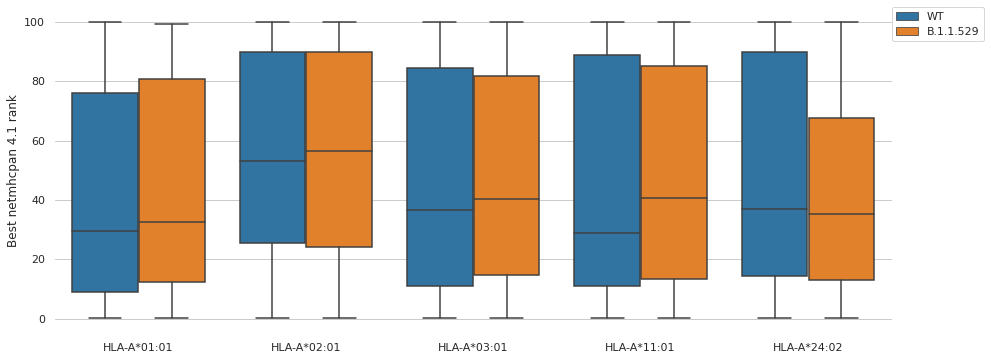

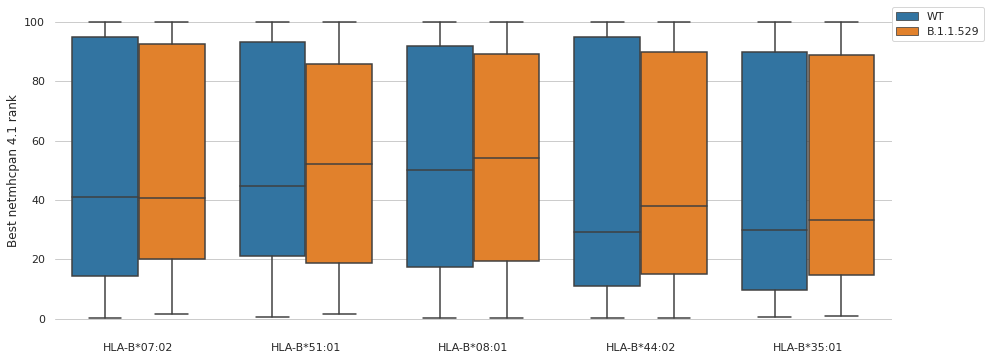

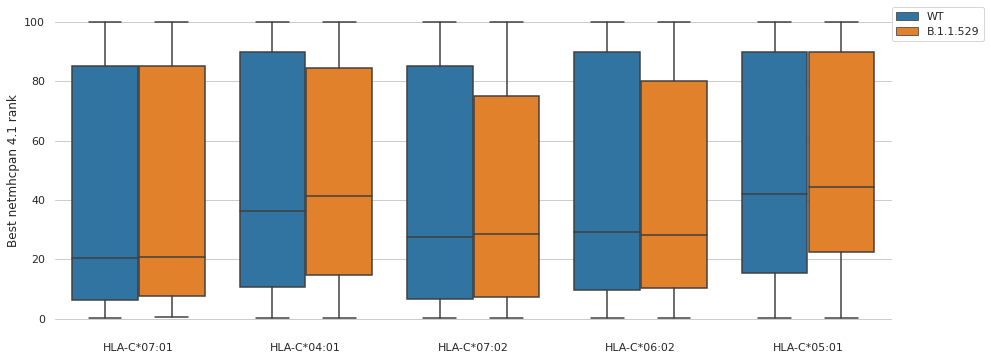

In [113]:
plot_boxplot(data=omicron_mhc_binding_europe, hla_allele="HLA-A", figname="figure_01_boxplot_omicron_europe_hla_a.png", compared_lineage="B.1.1.529")
plot_boxplot(data=omicron_mhc_binding_europe, hla_allele="HLA-B", figname="figure_01_boxplot_omicron_europe_hla_b.png", compared_lineage="B.1.1.529")
plot_boxplot(data=omicron_mhc_binding_europe, hla_allele="HLA-C", figname="figure_01_boxplot_omicron_europe_hla_c.png", compared_lineage="B.1.1.529")

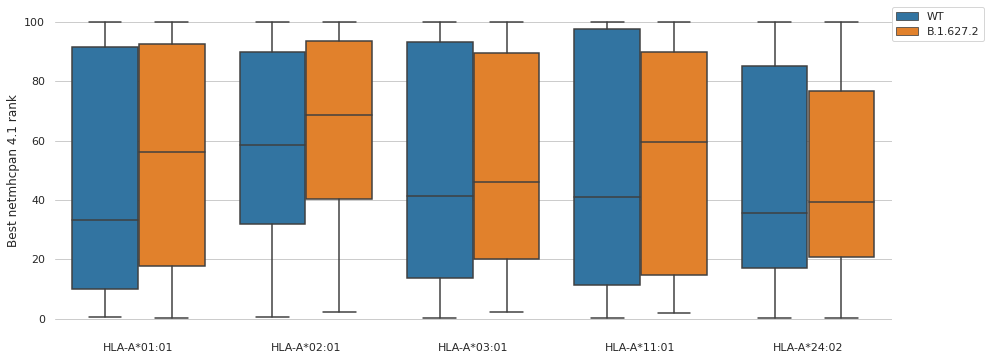

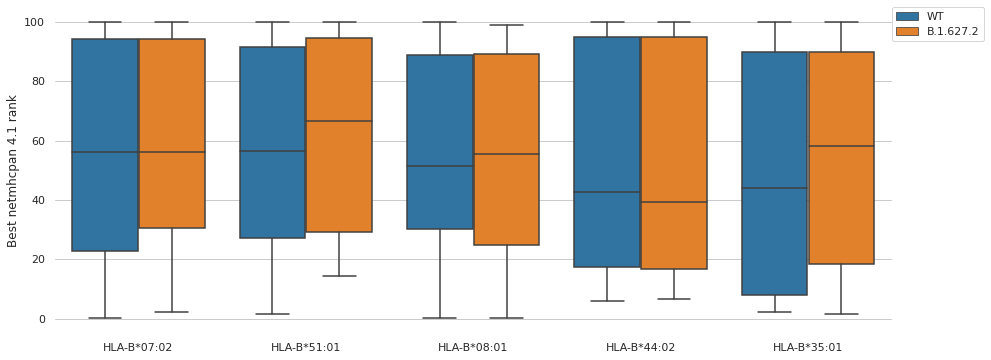

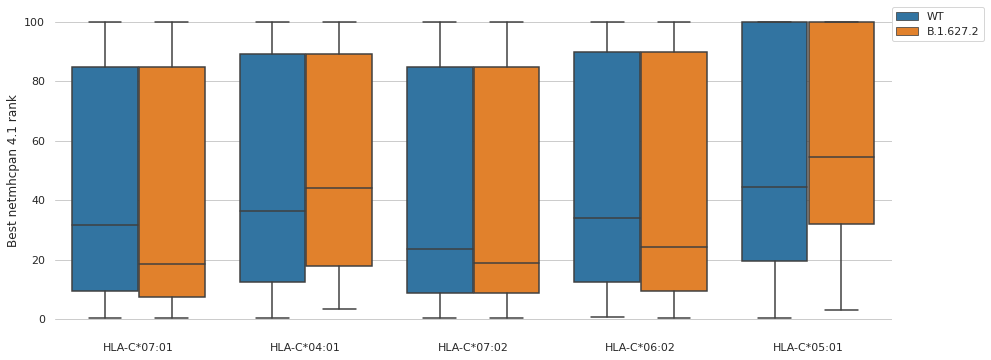

In [114]:
plot_boxplot(data=delta_mhc_binding_europe, hla_allele="HLA-A", figname="figure_01_boxplot_delta_europe_hla_a.png", compared_lineage="B.1.627.2")
plot_boxplot(data=delta_mhc_binding_europe, hla_allele="HLA-B", figname="figure_01_boxplot_delta_europe_hla_b.png", compared_lineage="B.1.627.2")
plot_boxplot(data=delta_mhc_binding_europe, hla_allele="HLA-C", figname="figure_01_boxplot_delta_europe_hla_c.png", compared_lineage="B.1.627.2")

### Scatterplot of quotient ranks vs WT rank

In [322]:
def plot_scatter_quotient(data, xlabel, ylabel, title, figname=None, option=3):
    fig = plt.figure(figsize=(15,10))
    #markers ={h:m for h, m in zip(data.hla_allele.unique(), cycle(["o", "s", "P", "v", "^"]))}
    markers ={h:m for h, m in zip(data.hla_allele.unique(), cycle(["+", "x", "1", "2", "|"]))}
    num_genes = len(data.gene.unique())
    if option == 1:
        g = sns.scatterplot(
            data=data, x="mhc_binding", y="quotient_mhc_binding", style="hla_allele", 
            hue="gene", s=100, alpha=0.6, markers=markers)
        plt.yscale('log')
        plt.axhline(y=0.8, color=sns.color_palette("colorblind")[3], linestyle='--')
        plt.axvline(x=10, color=sns.color_palette("colorblind")[3], linestyle='--')
    elif option == 2:
        g = sns.scatterplot(
            data=data, x="mhc_binding", y="homologous_mhc_binding", style="hla_allele", 
            hue="gene", s=100, alpha=0.6, markers=markers)
        plt.axvline(x=10, color=sns.color_palette("colorblind")[3], linestyle='--')
        plt.axhline(y=10, color=sns.color_palette("colorblind")[3], linestyle='--')
    elif option == 3:
        g = sns.scatterplot(
            data=data[(data.quotient_mhc_binding > 1.25)], 
            x="mhc_binding", y="quotient_mhc_binding", style="hla_allele", 
            hue="gene", s=100, markers=markers, palette=sns.color_palette("colorblind")[0:num_genes])
        sns.scatterplot(
            data=data[(data.quotient_mhc_binding < 0.8)], 
            x="mhc_binding", y="quotient_mhc_binding", style="hla_allele", 
            hue="gene", s=100, markers=markers, legend=False, palette=sns.color_palette("colorblind")[0:num_genes])
        sns.scatterplot(
            data=data[(data.quotient_mhc_binding >= 0.8) & (data.quotient_mhc_binding <= 1.25)], 
            x="mhc_binding", y="quotient_mhc_binding", color="grey", alpha=0.4, style=True, markers=["."], legend=False)
        plt.yscale('log')
        plt.xscale('log')
        rect=mpatches.Rectangle((data.mhc_binding.min() - 0.1, data.quotient_mhc_binding.min() - 1), 
                                width=data.mhc_binding.max() - data.mhc_binding.min() + 50, 
                                height=0.8 - data.quotient_mhc_binding.min() + 1, 
                                alpha=0.1,
                                facecolor=sns.color_palette("colorblind")[8])
        rect2=mpatches.Rectangle((data.mhc_binding.min() - 0.1, 1.25), 
                                width=data.mhc_binding.max() - data.mhc_binding.min() + 50, 
                                height=data.quotient_mhc_binding.max() - 1.25 + 10, 
                                alpha=0.1,
                                facecolor=sns.color_palette("colorblind")[9])
        plt.gca().add_patch(rect)
        plt.gca().add_patch(rect2)
        #plt.text(data.mhc_binding.min(), data.quotient_mhc_binding.min(), "Decreased binding (<0.8)", 
        #         horizontalalignment='left', size='medium', color='black')
        #plt.text(data.mhc_binding.min(), data.quotient_mhc_binding.max(), "Increased binding (>1.25)", 
        #         horizontalalignment='left', size='medium', color='black')
    elif option == 4:
        g = sns.scatterplot(
            data=data, x="mhc_binding", y="homologous_mhc_binding", style="hla_allele", 
            hue="gene", s=100, alpha=0.6, markers=markers)
        plt.yscale('log')
        plt.xscale('log')
        plt.axvline(x=10, color=sns.color_palette("colorblind")[3], linestyle='--')
        plt.axhline(y=10, color=sns.color_palette("colorblind")[3], linestyle='--')
        
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, size=20)
    plt.legend(loc='lower right', title=None, ncol=2, frameon=False, shadow=True)
    # this bit hacks the legend to remove variable names...
    num_hla_genes = len(data.gene.unique())
    vpacker = g.get_legend()._legend_handle_box.get_children()[0]
    vpacker._children = vpacker.get_children()[1:]
    vpacker.get_children()[num_hla_genes].get_children()[1].set_text("")
    sns.despine()
    if figname:
        fig.savefig(os.path.join(figures_folder, figname), dpi=dpi)

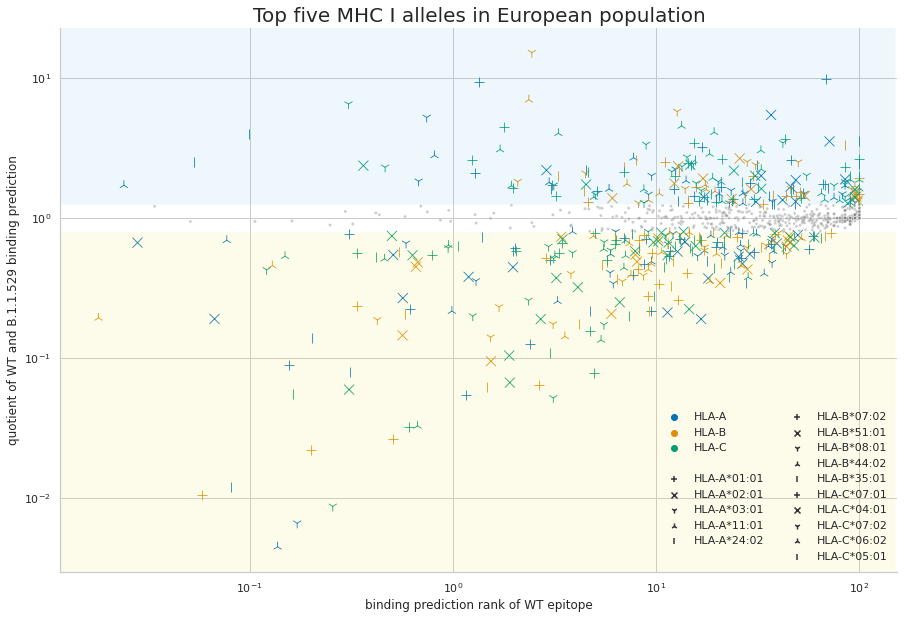

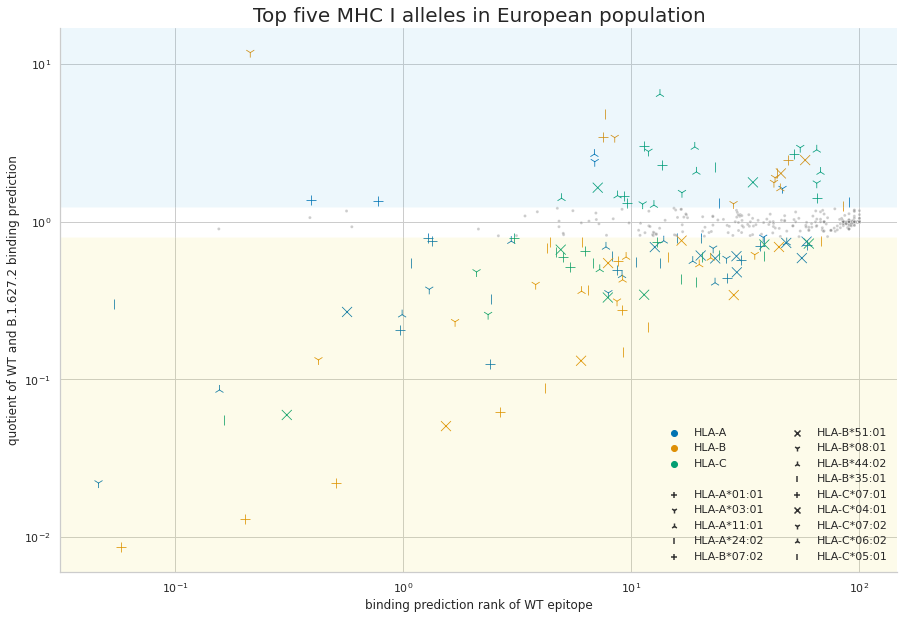

In [323]:
title="Top five MHC I alleles in European population"

plot_scatter_quotient(
    data=omicron_mhc_binding_europe, title=title, 
    xlabel="binding prediction rank of WT epitope",
    ylabel="quotient of WT and B.1.1.529 binding prediction",
    figname="figure_02_scatterplot_omicron_europe.png"
)
plot_scatter_quotient(
    data=delta_mhc_binding_europe,
    title=title,
    xlabel="binding prediction rank of WT epitope",
    ylabel="quotient of WT and B.1.627.2 binding prediction",
    figname="figure_02_scatterplot_delta_europe.png"
)
#plot_scatter_quotient(
#    data=delta_and_omicron_mhc_binding_europe,
#    title=title,
#    xlabel="binding prediction rank of B.1.627.2 epitope",
#    ylabel="quotient of B.1.627.2 and B.1.1.529 binding prediction",
#    figname="figure_02_scatterplot_delta_vs_omicron_europe.png"
#)

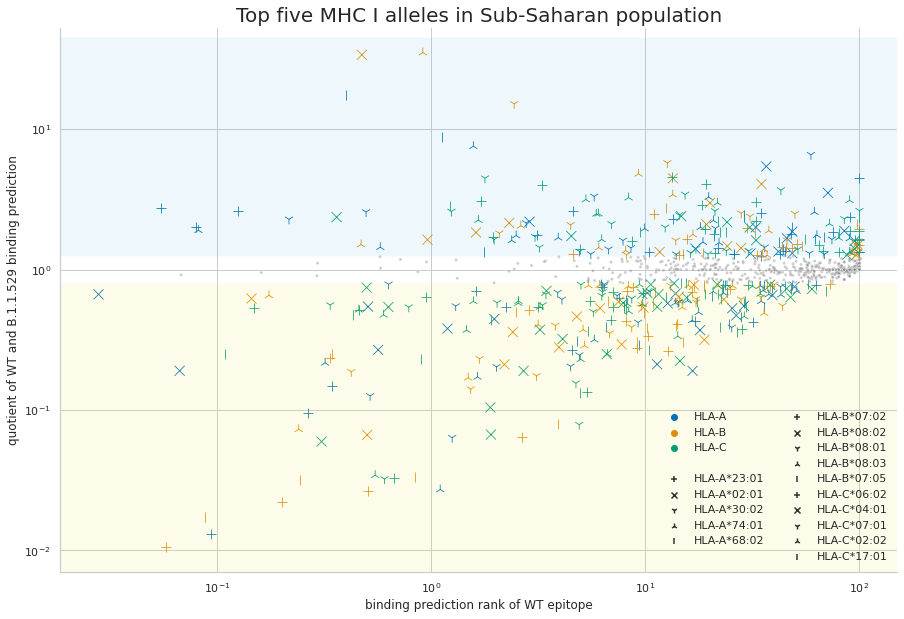

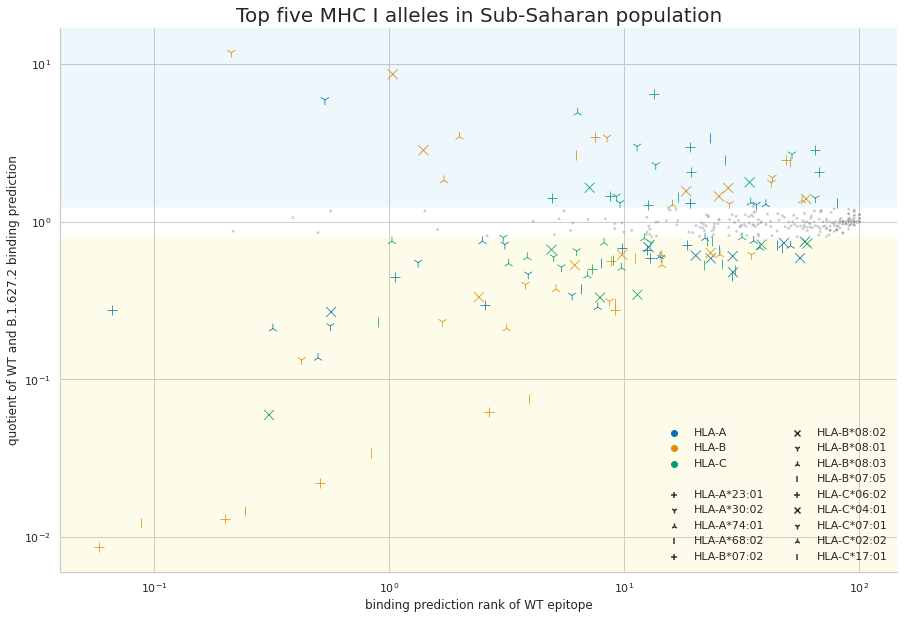

In [324]:
title="Top five MHC I alleles in Sub-Saharan population"

plot_scatter_quotient(
    data=omicron_mhc_binding_subsaharan, 
    title=title,
    xlabel="binding prediction rank of WT epitope",
    ylabel="quotient of WT and B.1.1.529 binding prediction",
    figname="figure_02_scatterplot_omicron_subsaharan.png"
)
plot_scatter_quotient(
    data=delta_mhc_binding_subsaharan,
    title=title,
    xlabel="binding prediction rank of WT epitope",
    ylabel="quotient of WT and B.1.627.2 binding prediction",
    figname="figure_02_scatterplot_delta_subsaharan.png"
)
#plot_scatter_quotient(
#    data=delta_and_omicron_mhc_binding_subsaharan,
#    title=title,
#    xlabel="binding prediction rank of B.1.627.2 epitope",
#    ylabel="quotient of B.1.627.2 and B.1.1.529 binding prediction",
#    figname="figure_02_scatterplot_delta_vs_omicron_subsaharan.png"
#)

In [325]:
omicron_mhc_binding_subsaharan.head()

,epitope,homologous_epitope,hla_allele,mhc_binding,homologous_mhc_binding,quotient_mhc_binding,gene
8,GSFCTQLNR,GSFCTQLKR,HLA-A*23:01,38.333,35.750,1.072252,HLA-A
26,SVLNDILSR,SVLNDIFSR,HLA-A*23:01,21.958,15.390,1.426771,HLA-A
28,VLNDILSRL,VLNDIFSRL,HLA-A*23:01,3.137,1.771,1.771316,HLA-A
31,NGVEGFNCYFPLQSY,NGVAGFNCYFPLRSY,HLA-A*23:01,62.500,80.000,0.781250,HLA-A
35,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVAS,AGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVAS,HLA-A*23:01,100.000,100.000,1.000000,HLA-A


In [326]:
def calculate_enrichment_decreased_binding(mhc_binding_data):
    a = mhc_binding_data[(mhc_binding_data.quotient_mhc_binding < 0.8) & 
                         (mhc_binding_data.mhc_binding < 10)].shape[0]
    b = mhc_binding_data[(mhc_binding_data.quotient_mhc_binding > 1.25) & 
                         (mhc_binding_data.mhc_binding < 10)].shape[0]
    c = mhc_binding_data[(mhc_binding_data.quotient_mhc_binding < 0.8) & 
                         (mhc_binding_data.mhc_binding >= 10)].shape[0]
    d = mhc_binding_data[(mhc_binding_data.quotient_mhc_binding > 1.25) & 
                         (mhc_binding_data.mhc_binding >= 10)].shape[0]
    oddsratio, pvalue = fisher_exact([[a, b], [c, d]])
    return pvalue

In [327]:
calculate_enrichment_decreased_binding(mhc_binding_data=omicron_mhc_binding_subsaharan)

3.243334744780939e-08

In [328]:
calculate_enrichment_decreased_binding(mhc_binding_data=omicron_mhc_binding_southafrica_black)

9.096262892685308e-05

In [329]:
calculate_enrichment_decreased_binding(mhc_binding_data=omicron_mhc_binding_europe)

1.13860396013757e-09

In [330]:
calculate_enrichment_decreased_binding(mhc_binding_data=delta_mhc_binding_subsaharan)

0.010325330962407852

In [331]:
calculate_enrichment_decreased_binding(mhc_binding_data=delta_mhc_binding_southafrica_black)

0.000970596923871719

In [332]:
calculate_enrichment_decreased_binding(mhc_binding_data=delta_mhc_binding_europe)

0.0093292279240275

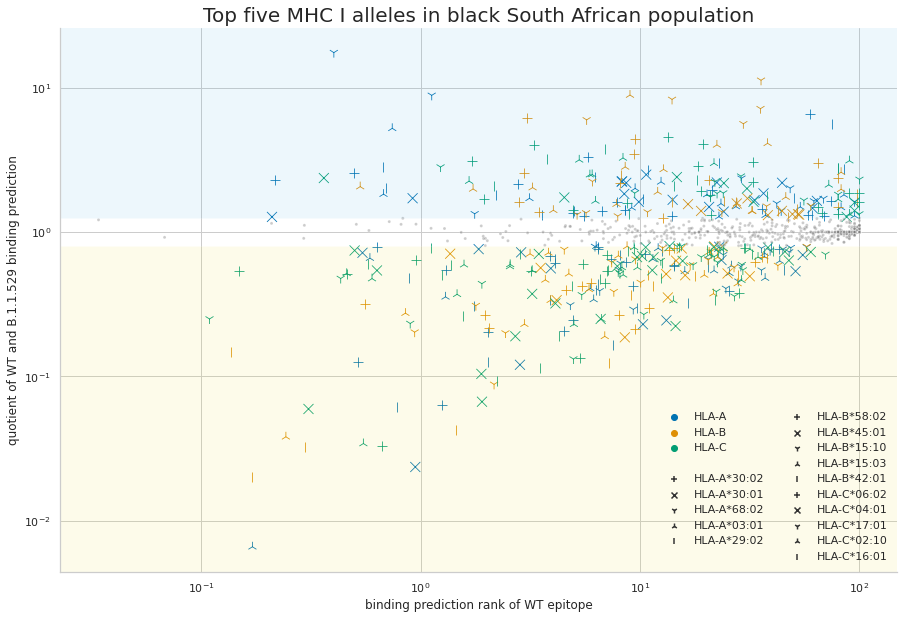

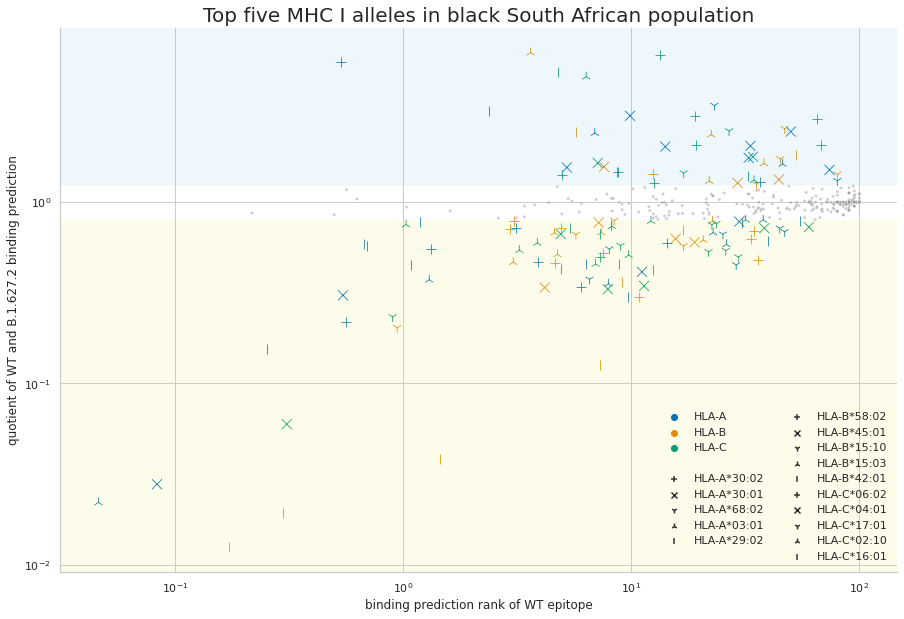

In [333]:
title="Top five MHC I alleles in black South African population"

plot_scatter_quotient(
    data=omicron_mhc_binding_southafrica_black, 
    title=title,
    xlabel="binding prediction rank of WT epitope",
    ylabel="quotient of WT and B.1.1.529 binding prediction",
    figname="figure_02_scatterplot_omicron_southafrica_black.png"
)
plot_scatter_quotient(
    data=delta_mhc_binding_southafrica_black,
    title=title,
    xlabel="binding prediction rank of WT epitope",
    ylabel="quotient of WT and B.1.627.2 binding prediction",
    figname="figure_02_scatterplot_delta_southafrica_black.png"
)
#plot_scatter_quotient(
#    data=delta_and_omicron_mhc_binding_south_africa_black,
#    title=title,
#    xlabel="binding prediction rank of B.1.627.2 epitope",
#    ylabel="quotient of B.1.627.2 and B.1.1.529 binding prediction",
#    figname="figure_02_scatterplot_delta_vs_omicron_southafrica_black.png"
#)

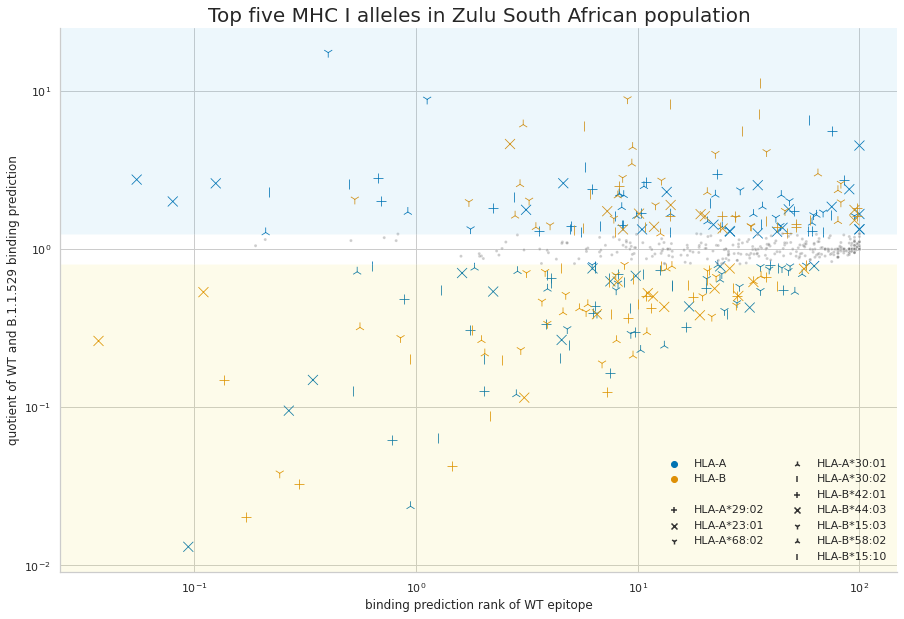

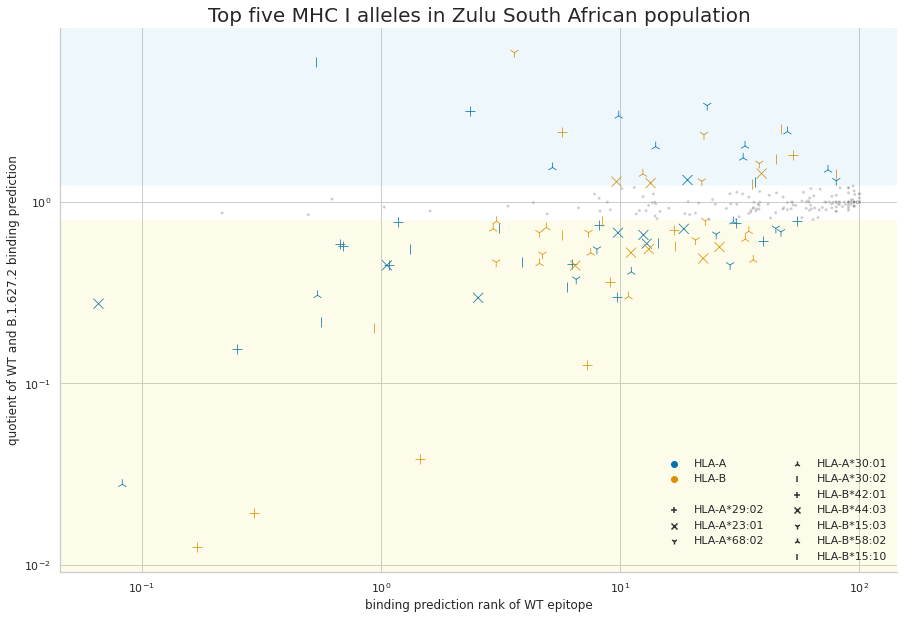

In [334]:
title="Top five MHC I alleles in Zulu South African population"

plot_scatter_quotient(
    data=omicron_mhc_binding_southafrica_zulu, 
    title=title,
    xlabel="binding prediction rank of WT epitope",
    ylabel="quotient of WT and B.1.1.529 binding prediction",
    figname="figure_02_scatterplot_omicron_southafrica_zulu.png"
)
plot_scatter_quotient(
    data=delta_mhc_binding_southafrica_zulu,
    title=title,
    xlabel="binding prediction rank of WT epitope",
    ylabel="quotient of WT and B.1.627.2 binding prediction",
    figname="figure_02_scatterplot_delta_southafrica_zulu.png"
)
#plot_scatter_quotient(
#    data=delta_and_omicron_mhc_binding_south_africa_zulu,
#    title=title,
#    xlabel="binding prediction rank of B.1.627.2 epitope",
#    ylabel="quotient of B.1.627.2 and B.1.1.529 binding prediction",
#    figname="figure_02_scatterplot_delta_vs_omicron_southafrica_zulu.png"
#)

### Distribution of quotient WT and mutated binding prediction rank

In [335]:
def plot_quotient_boxplot(data, figname, title, ylabel):
    fig = plt.figure(figsize=(10,6))
    box_plot = sns.boxplot(data=data, x="gene", y="quotient_mhc_binding")

    medians = data.groupby(['gene'])['quotient_mhc_binding'].median()
    counts = data.groupby(['gene'])['quotient_mhc_binding'].count()

    # add median and N annotations to the plot
    labels = []
    for xtick in box_plot.get_xticklabels():
        gene = xtick.get_text()
        label = "{gene}\nmedian={median:.3f}\nN={n}".format(gene=gene, median=medians[gene], n=counts[gene])
        labels.append(label)
    box_plot.set_xticklabels(labels)

    plt.yscale('log')
    plt.title(title, size=16)
    plt.ylabel(ylabel)
    plt.xlabel(None)
    sns.despine(bottom=True, left=True)
    fig.savefig(os.path.join(figures_folder, figname), dpi=dpi)

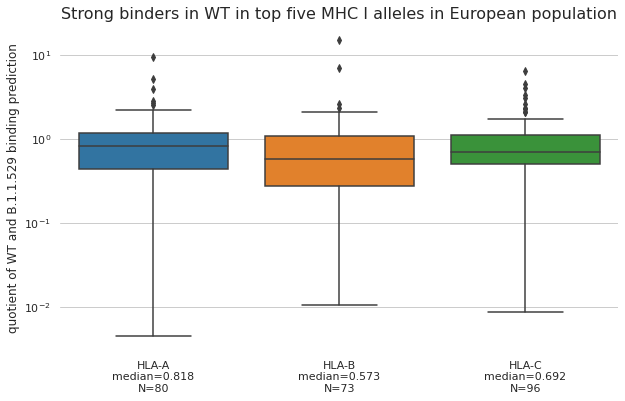

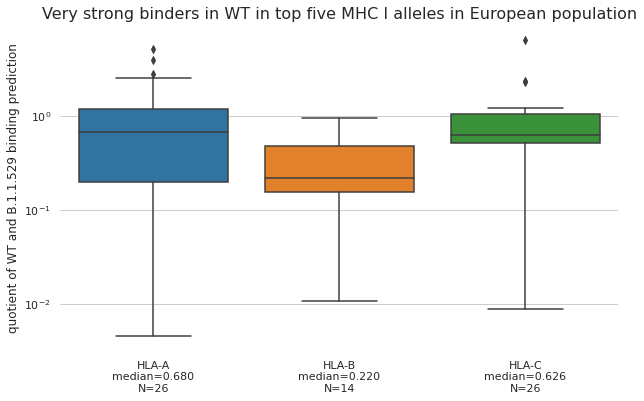

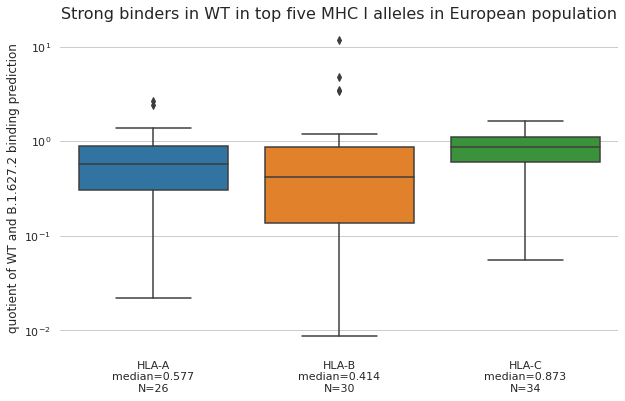

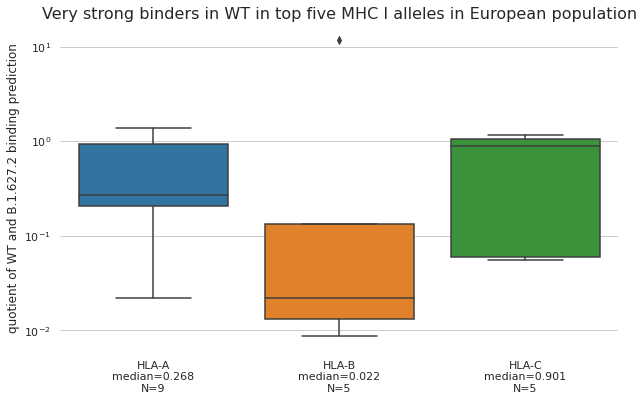

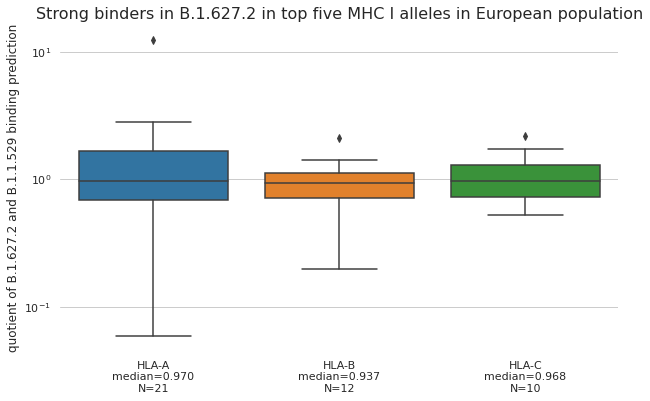

In [336]:
title = "Strong binders in WT in top five MHC I alleles in European population"
title2 = "Very strong binders in WT in top five MHC I alleles in European population"
title3 = "Strong binders in B.1.627.2 in top five MHC I alleles in European population"

plot_quotient_boxplot(
    data=omicron_mhc_binding_europe[omicron_mhc_binding_europe.mhc_binding < 10], 
    figname="figure_03_boxplot_omicron_europe_quotient_wt_binding_lt_10.png",
    ylabel="quotient of WT and B.1.1.529 binding prediction",
    title=title
)
plot_quotient_boxplot(
    data=omicron_mhc_binding_europe[omicron_mhc_binding_europe.mhc_binding < 1], 
    figname="figure_03_boxplot_omicron_europe_quotient_wt_binding_lt_1.png",
    ylabel="quotient of WT and B.1.1.529 binding prediction",
    title=title2
)
plot_quotient_boxplot(
    data=delta_mhc_binding_europe[delta_mhc_binding_europe.mhc_binding < 10], 
    figname="figure_03_boxplot_delta_europe_quotient_wt_binding_lt_10.png",
    ylabel="quotient of WT and B.1.627.2 binding prediction",
    title=title
)
plot_quotient_boxplot(
    data=delta_mhc_binding_europe[delta_mhc_binding_europe.mhc_binding < 1], 
    figname="figure_03_boxplot_delta_europe_quotient_wt_binding_lt_1.png",
    ylabel="quotient of WT and B.1.627.2 binding prediction",
    title=title2
)
plot_quotient_boxplot(
    data=delta_and_omicron_mhc_binding_europe[
        (delta_and_omicron_mhc_binding_europe.mhc_binding < 10) & 
        (delta_and_omicron_mhc_binding_europe.epitope != delta_and_omicron_mhc_binding_europe.homologous_epitope)], 
    figname="figure_03_boxplot_delta_vs_omicron_europe_quotient_binding_lt_10.png",
    ylabel="quotient of B.1.627.2 and B.1.1.529 binding prediction",
    title=title3
)

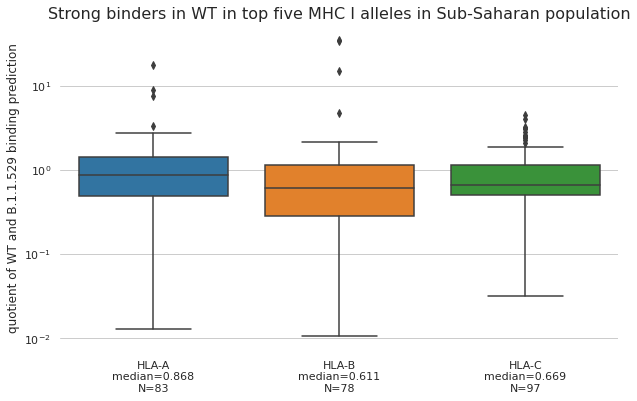

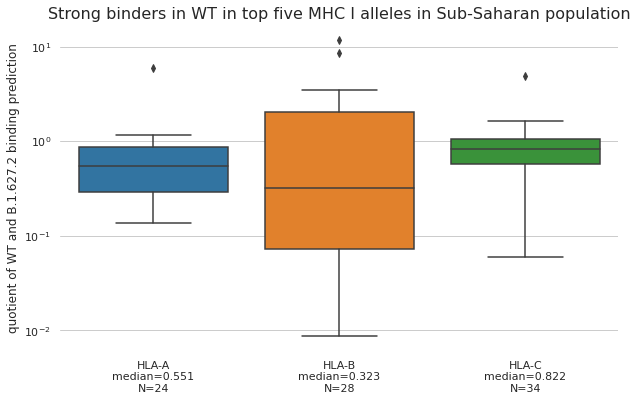

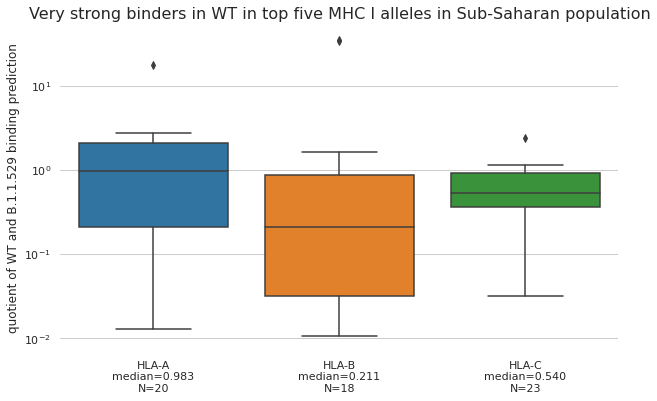

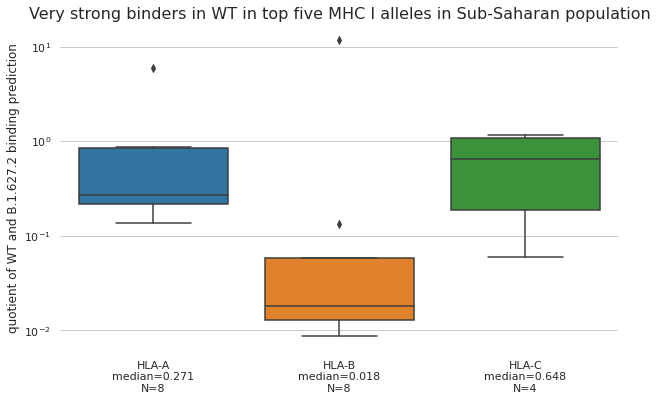

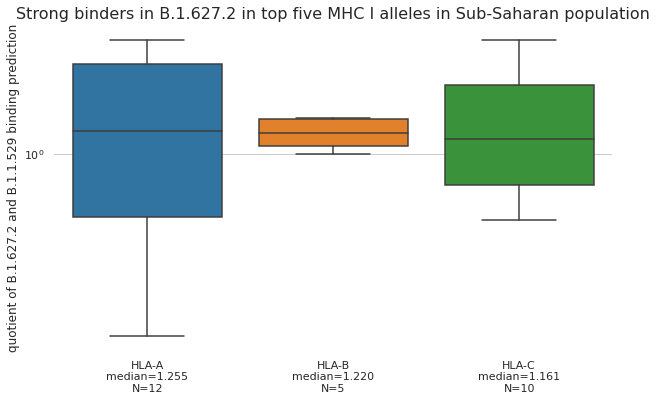

In [337]:
title = "Strong binders in WT in top five MHC I alleles in Sub-Saharan population"
title2 = "Very strong binders in WT in top five MHC I alleles in Sub-Saharan population"
title3 = "Strong binders in B.1.627.2 in top five MHC I alleles in Sub-Saharan population"

plot_quotient_boxplot(
    data=omicron_mhc_binding_subsaharan[omicron_mhc_binding_subsaharan.mhc_binding < 10], 
    figname="figure_03_boxplot_omicron_subsaharan_quotient_wt_binding_lt_10.png",
    ylabel="quotient of WT and B.1.1.529 binding prediction",
    title=title
)
plot_quotient_boxplot(
    data=delta_mhc_binding_subsaharan[delta_mhc_binding_subsaharan.mhc_binding < 10], 
    figname="figure_03_boxplot_delta_subsaharan_quotient_wt_binding_lt_10.png",
    ylabel="quotient of WT and B.1.627.2 binding prediction",
    title=title
)
plot_quotient_boxplot(
    data=omicron_mhc_binding_subsaharan[omicron_mhc_binding_subsaharan.mhc_binding < 1], 
    figname="figure_03_boxplot_omicron_subsaharan_quotient_wt_binding_lt_1.png",
    ylabel="quotient of WT and B.1.1.529 binding prediction",
    title=title2
)
plot_quotient_boxplot(
    data=delta_mhc_binding_subsaharan[delta_mhc_binding_subsaharan.mhc_binding < 1], 
    figname="figure_03_boxplot_delta_subsaharan_quotient_wt_binding_lt_1.png",
    ylabel="quotient of WT and B.1.627.2 binding prediction",
    title=title2
)
plot_quotient_boxplot(
    data=delta_and_omicron_mhc_binding_subsaharan[
        (delta_and_omicron_mhc_binding_subsaharan.mhc_binding < 10) & 
        (delta_and_omicron_mhc_binding_subsaharan.epitope != delta_and_omicron_mhc_binding_subsaharan.homologous_epitope)], 
    figname="figure_03_boxplot_delta_vs_omicron_subsaharan_quotient_binding_lt_10.png",
    ylabel="quotient of B.1.627.2 and B.1.1.529 binding prediction",
    title=title3
)

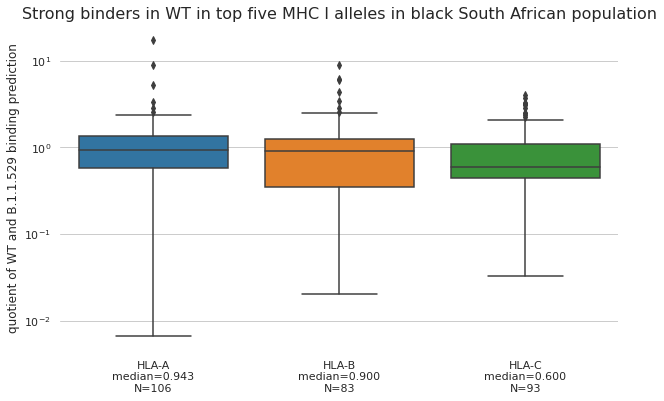

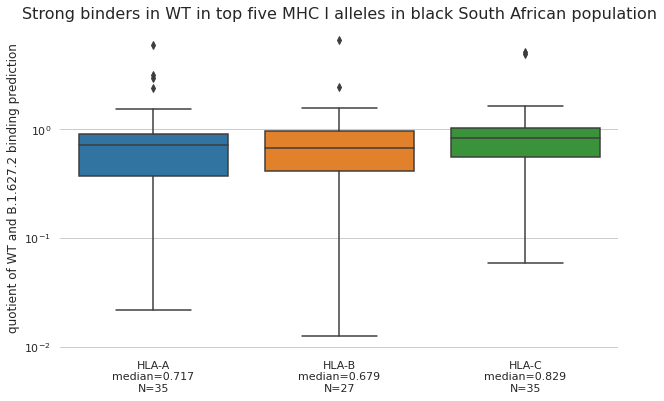

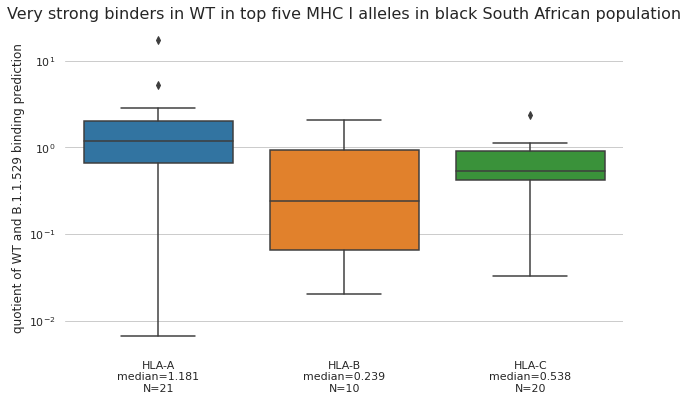

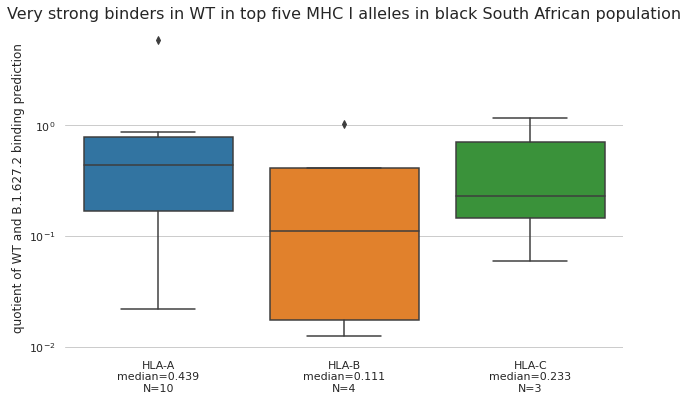

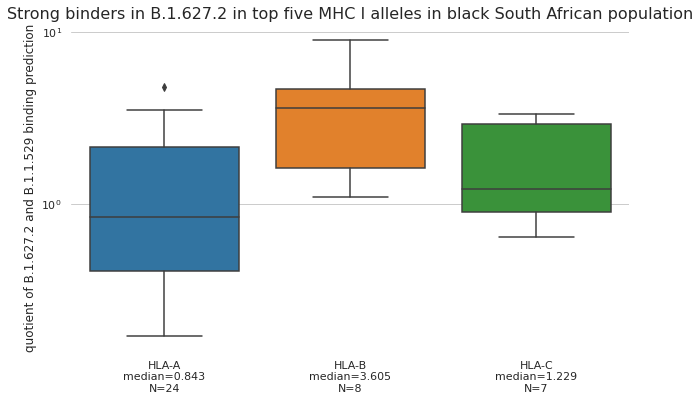

In [338]:
title = "Strong binders in WT in top five MHC I alleles in black South African population"
title2 = "Very strong binders in WT in top five MHC I alleles in black South African population"
title3 = "Strong binders in B.1.627.2 in top five MHC I alleles in black South African population"

plot_quotient_boxplot(
    data=omicron_mhc_binding_southafrica_black[omicron_mhc_binding_southafrica_black.mhc_binding < 10], 
    figname="figure_03_boxplot_omicron_southafrica_black_quotient_wt_binding_lt_10.png",
    ylabel="quotient of WT and B.1.1.529 binding prediction",
    title=title
)
plot_quotient_boxplot(
    data=delta_mhc_binding_southafrica_black[delta_mhc_binding_southafrica_black.mhc_binding < 10], 
    figname="figure_03_boxplot_delta_black_southafrica_quotient_wt_binding_lt_10.png",
    ylabel="quotient of WT and B.1.627.2 binding prediction",
    title=title
)
plot_quotient_boxplot(
    data=omicron_mhc_binding_southafrica_black[omicron_mhc_binding_southafrica_black.mhc_binding < 1], 
    figname="figure_03_boxplot_omicron_southafrica_black_quotient_wt_binding_lt_1.png",
    ylabel="quotient of WT and B.1.1.529 binding prediction",
    title=title2
)
plot_quotient_boxplot(
    data=delta_mhc_binding_southafrica_black[delta_mhc_binding_southafrica_black.mhc_binding < 1], 
    figname="figure_03_boxplot_delta_black_southafrica_quotient_wt_binding_lt_1.png",
    ylabel="quotient of WT and B.1.627.2 binding prediction",
    title=title2
)
plot_quotient_boxplot(
    data=delta_and_omicron_mhc_binding_south_africa_black[
        (delta_and_omicron_mhc_binding_south_africa_black.mhc_binding < 10) & 
        (delta_and_omicron_mhc_binding_south_africa_black.epitope != delta_and_omicron_mhc_binding_south_africa_black.homologous_epitope)], 
    figname="figure_03_boxplot_delta_vs_omicron_black_southafrica_quotient_binding_lt_10.png",
    ylabel="quotient of B.1.627.2 and B.1.1.529 binding prediction",
    title=title3
)

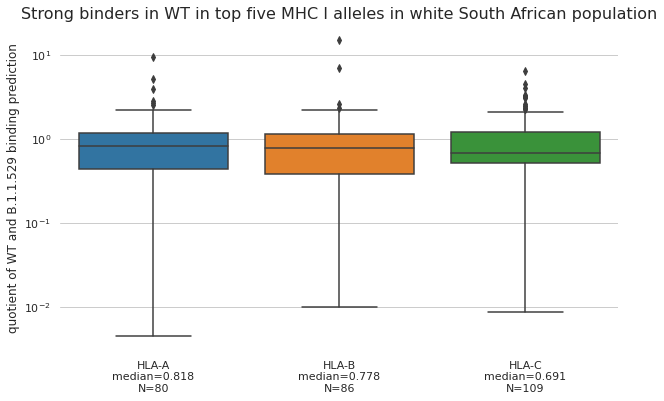

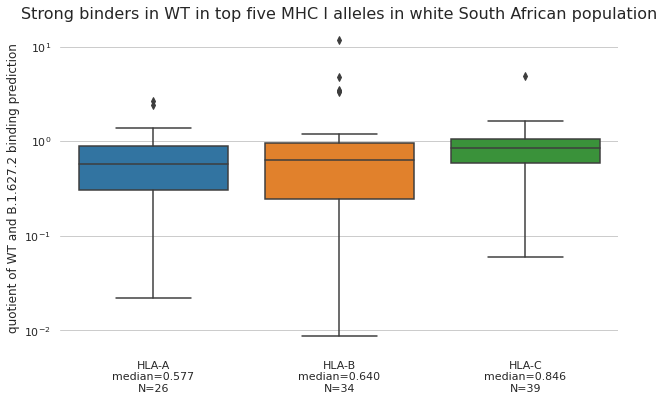

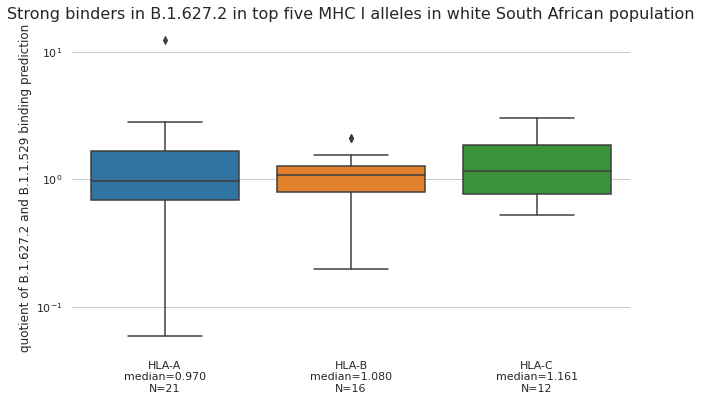

In [339]:
title = "Strong binders in WT in top five MHC I alleles in white South African population"
title2 = "Very strong binders in WT in top five MHC I alleles in white South African population"
title3 = "Strong binders in B.1.627.2 in top five MHC I alleles in white South African population"

plot_quotient_boxplot(
    data=omicron_mhc_binding_southafrica_white[omicron_mhc_binding_southafrica_white.mhc_binding < 10], 
    figname="figure_03_boxplot_omicron_southafrica_white_quotient_wt_binding_lt_10.png",
    ylabel="quotient of WT and B.1.1.529 binding prediction",
    title=title
)
plot_quotient_boxplot(
    data=delta_mhc_binding_southafrica_white[delta_mhc_binding_southafrica_white.mhc_binding < 10], 
    figname="figure_03_boxplot_delta_white_southafrica_quotient_wt_binding_lt_10.png",
    ylabel="quotient of WT and B.1.627.2 binding prediction",
    title=title
)
plot_quotient_boxplot(
    data=delta_and_omicron_mhc_binding_south_africa_white[
        (delta_and_omicron_mhc_binding_south_africa_white.mhc_binding < 10) & 
        (delta_and_omicron_mhc_binding_south_africa_white.epitope != delta_and_omicron_mhc_binding_south_africa_white.homologous_epitope)], 
    figname="figure_03_boxplot_delta_vs_omicron_white_southafrica_quotient_binding_lt_10.png",
    ylabel="quotient of B.1.627.2 and B.1.1.529 binding prediction",
    title=title3
)

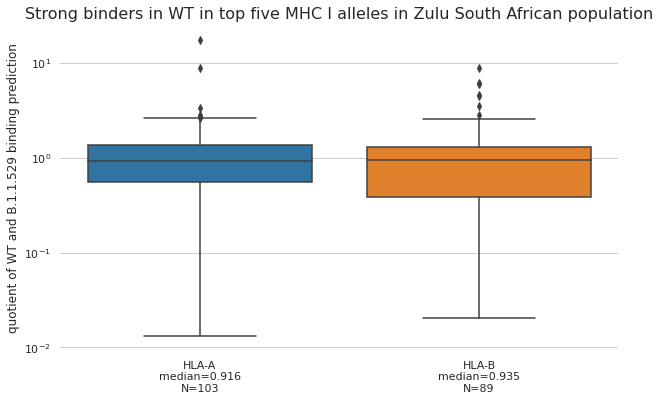

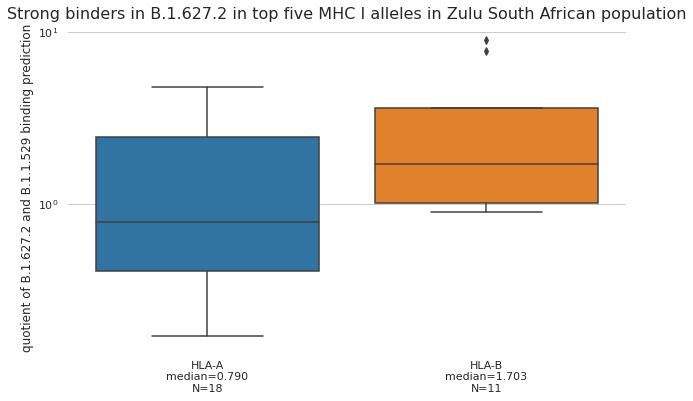

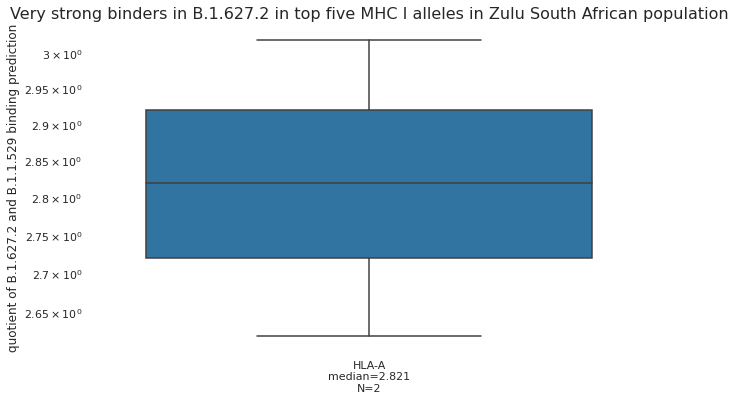

In [340]:
title = "Strong binders in WT in top five MHC I alleles in Zulu South African population"
title2 = "Very strong binders in WT in top five MHC I alleles in Zulu South African population"
title3 = "Strong binders in B.1.627.2 in top five MHC I alleles in Zulu South African population"
title4 = "Very strong binders in B.1.627.2 in top five MHC I alleles in Zulu South African population"

plot_quotient_boxplot(
    data=omicron_mhc_binding_southafrica_zulu[omicron_mhc_binding_southafrica_zulu.mhc_binding < 10], 
    figname="figure_03_boxplot_omicron_southafrica_zulu_quotient_wt_binding_lt_10.png",
    ylabel="quotient of WT and B.1.1.529 binding prediction",
    title=title
)
plot_quotient_boxplot(
    data=delta_and_omicron_mhc_binding_south_africa_zulu[
        (delta_and_omicron_mhc_binding_south_africa_zulu.mhc_binding < 10) & 
        (delta_and_omicron_mhc_binding_south_africa_zulu.epitope != delta_and_omicron_mhc_binding_south_africa_zulu.homologous_epitope)], 
    figname="figure_03_boxplot_delta_vs_omicron_zulu_southafrica_quotient_binding_lt_10.png",
    ylabel="quotient of B.1.627.2 and B.1.1.529 binding prediction",
    title=title3
)
plot_quotient_boxplot(
    data=delta_and_omicron_mhc_binding_south_africa_zulu[
        (delta_and_omicron_mhc_binding_south_africa_zulu.mhc_binding < 1) & 
        (delta_and_omicron_mhc_binding_south_africa_zulu.epitope != delta_and_omicron_mhc_binding_south_africa_zulu.homologous_epitope)], 
    figname="figure_03_boxplot_delta_vs_omicron_zulu_southafrica_quotient_binding_lt_1.png",
    ylabel="quotient of B.1.627.2 and B.1.1.529 binding prediction",
    title=title4
)

### Enriched mutations in predicted decreased binding epitopes

When plotting the WT binding versus the quotient of the WT binding over the homologous binding we identified a subset of epitope-HLA allele pairs of interest.
The pairs of epitope-HLA allele with a strong binding prediction in the WT that show a decreased predicted binding in a homologous epitope are coherent with the hypothesis of an immune escape mechanism. 
But the signal may be distributed across multiple epitopes, HLA genes and alleles difficulting the interpretation. 
Furthermore, a given homologous epitope may be overlapped by more than one mutation. 
Just from these results it is challenging to point out a particular mutation as an immune escape mutation.

We are comparing epitopes in the WT reported as having a positive T-cell recognition or MHC binding in IEDB, with its homologous counterpart in a particular SARS-CoV-2 lineage (ie: in this study either B.1.1.529 or B.1.627.2). 
The homologous epitope is the product of at least one mutation but possibly more. 
We test every mutation in the spike protein in a given lineage for enrichment in the epitope-HLA alleles pairs of interest as compared to the complete dataset with the aim of identifying those mutations that comply most to the immune escape expected behaviour.

For this purpose we will use the following contingency table, where X is a particular mutation:

|                    | decreased binding | no decreased binding |
|--------------------|-------------------|----------------------|
| has X mutation | a                 | b                    |
| no X mutation  | c                 | d                    |

We consider a strong binding prediction in the WT epitope every epitope-HLA allele pair with a netMHCpan rank below 10.
Also we consider a decreased predicted binding in the homologous epitope any triplet epitope-homologous epitope-HLA alleles with a binding prediction rank quotient lower than 0.9.

In [341]:
strong_binding_thr = 10
decreased_binding_thr = 0.8
significance_threshold = 0.001

In [342]:
# there is a lot of overlap between mutations
len(set(top5_european_hla_alleles + 
    top5_south_africa_black_hla_alleles + 
    top5_south_africa_white_hla_alleles + 
    top5_south_africa_zulu_hla_alleles + 
    top5_subsaharan_hla_alleles))

35

In [343]:
test = pd.concat([omicron_mhc_binding_europe, omicron_mhc_binding_subsaharan, omicron_mhc_binding_southafrica_black, 
                  omicron_mhc_binding_southafrica_white, omicron_mhc_binding_southafrica_zulu])
test.set_index(["epitope", "hla_allele"]).drop_duplicates().shape

(2173, 5)

In [344]:
def calculate_enrichment_mutation(data, overlapped_epitopes, strong_binding_thr = strong_binding_thr):
    a = data[
        (data.homologous_epitope.isin(overlapped_epitopes)) &
        (data.mhc_binding < strong_binding_thr) &
        (data.quotient_mhc_binding < decreased_binding_thr)].shape[0]
    b = data[
        (data.homologous_epitope.isin(overlapped_epitopes)) &
        ((data.mhc_binding >= strong_binding_thr) |
        (data.quotient_mhc_binding >= decreased_binding_thr))].shape[0]
    c = data[
        (~data.homologous_epitope.isin(overlapped_epitopes)) &
        (data.mhc_binding < strong_binding_thr) &
        (data.quotient_mhc_binding < decreased_binding_thr)].shape[0]
    d = data[
        (~data.homologous_epitope.isin(overlapped_epitopes)) &
        ((data.mhc_binding >= strong_binding_thr) |
        (data.quotient_mhc_binding >= decreased_binding_thr))].shape[0]
    oddsratio, pvalue = fisher_exact([[a, b], [c, d]])
    return oddsratio, pvalue, a, b, c, d

def calculate_enrichment(mhc_binding_europe, mhc_binding_subsaharan, mhc_binding_sa_black, 
                         mhc_binding_sa_white, mhc_binding_sa_zulu, overlapping_mutations):
    rows = []
    for mutation in overlapping_mutations.mutation.unique():
        overlapped_epitopes = overlapping_mutations[overlapping_mutations.mutation == mutation].homologous_epitope
        mhc_binding = pd.concat([mhc_binding_europe, mhc_binding_subsaharan, mhc_binding_sa_black, 
                          mhc_binding_sa_white, mhc_binding_sa_zulu]).set_index(["epitope", "hla_allele"]).drop_duplicates().reset_index()
        
        oddsratio, pvalue, a, b, c, d = calculate_enrichment_mutation(data=mhc_binding, overlapped_epitopes=overlapped_epitopes)
        
        rows.append([mutation, pvalue, oddsratio, a, b, c, d])
    mutation_enrichment = pd.DataFrame(data=rows, columns=["mutation", "pvalue", "OR", "a", "b", "c", "d"])
    mutation_enrichment["adj_pvalue"] = multipletests(mutation_enrichment.pvalue, method="fdr_bh")[1]
    mutation_enrichment["significant"] = mutation_enrichment[["adj_pvalue", "OR"]].apply(
        lambda x: "not significant" if x[0] >= significance_threshold else "significant & OR > 1.0" if x[1] > 1.0 else "significant & OR <= 1.0", axis=1)
    return mutation_enrichment

In [345]:
delta_overlapping_mutations.head()

,epitope,homologous_epitope,mutation
0,YLYRLFRKSNLKPFE,YRYRLFRKSNLKPFE,L452R
1,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVAS,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVAS,P681R
2,FCNDPFLGVYY,FCNDPFLDVYY,G142D
3,KSWMESEFRVY,KSWMESGVY,E156G
4,KSWMESEFRVY,KSWMESGVY,FR157


In [346]:
delta_overlapping_mutations[delta_overlapping_mutations.mutation == "P681R"].shape

(8, 3)

In [347]:
delta_mutation_enrichment = calculate_enrichment(
    mhc_binding_europe=delta_mhc_binding_europe, 
    mhc_binding_subsaharan=delta_mhc_binding_subsaharan,
    mhc_binding_sa_black=delta_mhc_binding_southafrica_black,
    mhc_binding_sa_white=delta_mhc_binding_southafrica_white,
    mhc_binding_sa_zulu=delta_mhc_binding_southafrica_zulu,
    overlapping_mutations=delta_overlapping_mutations
)
delta_mutations_df = pd.DataFrame(data=delta_mutations, columns=["position", "reference", "alternate"])
delta_mutations_df["identifier"] = delta_mutations_df.apply(lambda x: "{}{}{}".format(x[1], str(x[0]), x[2]), axis=1)
delta_mutation_enrichment = pd.merge(left=delta_mutation_enrichment, right=delta_mutations_df, left_on="mutation", right_on="identifier")
delta_mutation_enrichment.to_csv(os.path.join(data_folder, "delta_mutation_enrichment.csv"), index=False)
#delta_mutation_enrichment[delta_mutation_enrichment.significant].sort_values("position")
delta_mutation_enrichment.sort_values("position")

,mutation,pvalue,OR,a,b,c,d,adj_pvalue,significant,position,reference,alternate,identifier
6,T19R,0.806351,0.784314,4,30,119,700,0.907145,not significant,19,T,R,T19R
2,G142D,1.000000,1.010377,17,100,106,630,1.000000,not significant,142,G,D,G142D
3,E156G,0.471691,1.236088,19,94,104,636,0.606460,not significant,156,E,G,E156G
4,FR157,0.471691,1.236088,19,94,104,636,0.606460,not significant,157,FR,,FR157
0,L452R,0.000110,0.382415,19,236,104,494,0.000497,significant & OR <= 1.0,452,L,R,L452R
8,T478K,0.014901,0.000000,0,30,123,700,0.044703,not significant,478,T,K,T478K
5,D614G,0.000006,3.624575,25,48,98,682,0.000054,significant & OR > 1.0,614,D,G,D614G
1,P681R,0.227878,1.300967,39,192,84,538,0.410180,not significant,681,P,R,P681R
7,D950N,0.146526,0.000000,0,15,123,715,0.329683,not significant,950,D,N,D950N


In [348]:
omicron_mutation_enrichment = calculate_enrichment(
    mhc_binding_europe=omicron_mhc_binding_europe, 
    mhc_binding_subsaharan=omicron_mhc_binding_subsaharan,
    mhc_binding_sa_black=omicron_mhc_binding_southafrica_black,
    mhc_binding_sa_white=omicron_mhc_binding_southafrica_white,
    mhc_binding_sa_zulu=omicron_mhc_binding_southafrica_zulu,
    overlapping_mutations=omicron_overlapping_mutations
)
omicron_mutations_df = pd.DataFrame(data=omicron_mutations, columns=["position", "reference", "alternate"])
omicron_mutations_df["identifier"] = omicron_mutations_df.apply(lambda x: "{}{}{}".format(x[1], str(x[0]), x[2]), axis=1)
omicron_mutation_enrichment = pd.merge(left=omicron_mutation_enrichment, right=omicron_mutations_df, left_on="mutation", right_on="identifier")
omicron_mutation_enrichment.to_csv(os.path.join(data_folder, "omicron_mutation_enrichment.csv"), index=False)
#omicron_mutation_enrichment[omicron_mutation_enrichment.significant].sort_values("position")
omicron_mutation_enrichment.sort_values("position")

,mutation,pvalue,OR,a,b,c,d,adj_pvalue,significant,position,reference,alternate,identifier
9,A67V,7.972837e-05,0.000000,0,65,300,1808,2.551308e-04,significant & OR <= 1.0,67,A,V,A67V
31,HV69,7.620128e-02,0.186480,1,33,299,1840,1.283390e-01,not significant,69,HV,,HV69
7,T95I,8.840288e-08,0.108888,3,159,297,1714,4.714820e-07,significant & OR <= 1.0,95,T,I,T95I
15,G142D,2.363390e-01,0.000000,0,13,300,1860,3.230980e-01,not significant,142,G,D,G142D
16,VYY143,1.891827e-07,5.346981,21,26,279,1847,8.648350e-07,significant & OR > 1.0,143,VYY,,VYY143
12,N211,3.737260e-13,6.913534,34,34,266,1839,5.979617e-12,significant & OR > 1.0,211,N,,N211
13,L212I,3.737260e-13,6.913534,34,34,266,1839,5.979617e-12,significant & OR > 1.0,212,L,I,L212I
22,214EPE,5.613317e-08,7.408245,18,16,282,1857,3.592523e-07,significant & OR > 1.0,214,,EPE,214EPE
8,G339D,2.645103e-01,0.639032,8,77,292,1796,3.230980e-01,not significant,339,G,D,G339D
24,S371L,2.641312e-01,0.793421,32,245,268,1628,3.230980e-01,not significant,371,S,L,S371L


In [349]:
negative_immunogenic_aminoacids = ["S"]
positive_immunogenic_aminoacids = ["F", "I", "K", "M", "W", "Y"]
omicron_mutation_enrichment[(omicron_mutation_enrichment.alternate.isin(negative_immunogenic_aminoacids)) | 
                            (omicron_mutation_enrichment.reference.isin(positive_immunogenic_aminoacids))]

,mutation,pvalue,OR,a,b,c,d,adj_pvalue,significant,position,reference,alternate,identifier
11,Y505H,9.669762e-11,3.337348,57,123,243,1750,1.031441e-09,significant & OR > 1.0,505,Y,H,Y505H
18,G446S,2.201614e-04,0.301545,8,156,292,1717,6.404694e-04,significant & OR <= 1.0,446,G,S,G446S
21,K417N,2.332277e-05,2.779321,30,72,270,1801,8.292541e-05,significant & OR > 1.0,417,K,N,K417N
27,G496S,1.395157e-02,1.766183,29,107,271,1766,2.790314e-02,not significant,496,G,S,G496S


In [350]:
delta_mutation_enrichment[(delta_mutation_enrichment.alternate.isin(negative_immunogenic_aminoacids)) | 
                            (delta_mutation_enrichment.reference.isin(positive_immunogenic_aminoacids))]

,mutation,pvalue,OR,a,b,c,d,adj_pvalue,significant,position,reference,alternate,identifier


In [351]:
# merge close by mutations with equivalent significance results for plotting
omicron_mutation_enrichment = omicron_mutation_enrichment[~omicron_mutation_enrichment.mutation.isin(["T478K", "P681H"])]
omicron_mutation_enrichment.mutation = omicron_mutation_enrichment.mutation.transform(
    lambda x: "S477N+T478K" if x == "S477N" else "N679K+P681H" if x == "N679K" else "N211+L212I" if x == "N211" else x)
omicron_mutation_enrichment.sort_values("position")

,mutation,pvalue,OR,a,b,c,d,adj_pvalue,significant,position,reference,alternate,identifier
9,A67V,7.972837e-05,0.000000,0,65,300,1808,2.551308e-04,significant & OR <= 1.0,67,A,V,A67V
31,HV69,7.620128e-02,0.186480,1,33,299,1840,1.283390e-01,not significant,69,HV,,HV69
7,T95I,8.840288e-08,0.108888,3,159,297,1714,4.714820e-07,significant & OR <= 1.0,95,T,I,T95I
15,G142D,2.363390e-01,0.000000,0,13,300,1860,3.230980e-01,not significant,142,G,D,G142D
16,VYY143,1.891827e-07,5.346981,21,26,279,1847,8.648350e-07,significant & OR > 1.0,143,VYY,,VYY143
12,N211+L212I,3.737260e-13,6.913534,34,34,266,1839,5.979617e-12,significant & OR > 1.0,211,N,,N211
13,L212I,3.737260e-13,6.913534,34,34,266,1839,5.979617e-12,significant & OR > 1.0,212,L,I,L212I
22,214EPE,5.613317e-08,7.408245,18,16,282,1857,3.592523e-07,significant & OR > 1.0,214,,EPE,214EPE
8,G339D,2.645103e-01,0.639032,8,77,292,1796,3.230980e-01,not significant,339,G,D,G339D
24,S371L,2.641312e-01,0.793421,32,245,268,1628,3.230980e-01,not significant,371,S,L,S371L


In [352]:
def plot_enriched_mutations(data, figname, title, annotations=True, reposition=False):
    
    data = data[data.mutation != "L212I"].sort_values("significant", ascending=False)
    
    fig = plt.figure(figsize=(12,6))
    g = sns.scatterplot(data=data, x="position", y="adj_pvalue", hue="significant", style="significant", legend=True, 
                        palette=[sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[5], sns.color_palette("colorblind")[7]])
        
    # annotate significant mutations. Labels may overlap...
    if annotations:
        for idx, row in data[(data.significant == "significant & OR > 1.0")].iterrows():
            if row.mutation == "VYY143" and reposition:
                plt.text(row.position - 3, row.adj_pvalue * 4, 
                         row.mutation, horizontalalignment='left', size='large', color='black')
            else:
                plt.text(row.position + 10, row.adj_pvalue, 
                     row.mutation, horizontalalignment='left', 
                     verticalalignment="center_baseline", size='large', color='black')

    # remove the size of the dots from the legend
    vpacker = g.get_legend()._legend_handle_box.get_children()[0]
    vpacker._children = vpacker.get_children()[0:4]
    #vpacker.get_children()[0].get_children()[1].set_text("")
    
    # draw domains
    g.axes.axvspan(33, 337, alpha=0.2, color=sns.color_palette("colorblind")[0])
    plt.text(33 + 10, data.adj_pvalue.max() + 0.1, "S1-N", horizontalalignment='left', size='small', color='black')
    g.axes.axvspan(349, 526, alpha=0.2, color=sns.color_palette("colorblind")[1])
    plt.text(349 + 10, data.adj_pvalue.max() + 0.1, "RBD", horizontalalignment='left', size='small', color='black')
    g.axes.axvspan(536, 592, alpha=0.2, color=sns.color_palette("colorblind")[2])
    plt.text(536 + 10, data.adj_pvalue.max() + 0.1, "S1-C", horizontalalignment='left', size='small', color='black')
    g.axes.axvspan(711, 1232, alpha=0.2, color=sns.color_palette("colorblind")[3])
    plt.text(711 + 10, data.adj_pvalue.max() + 0.1, "S2", horizontalalignment='left', size='small', color='black')
    
    # draw significance line
    plt.axhline(y=significance_threshold, color=sns.color_palette("colorblind")[3], linestyle='--')
    plt.text(x=1080, y=significance_threshold - 0.0002, s="p-value={}".format(significance_threshold), 
             horizontalalignment='left', size='small', color='black')
    
    # log transform and reverse p-value
    plt.yscale("log")
    plt.gca().invert_yaxis()

    # set labels
    plt.title(title, size=20)
    plt.xlabel("amino acid position in spike protein")
    plt.ylabel("-log(adj. p-value)")
    plt.legend(title=None)
    sns.despine(bottom=True, left=True)
    
    fig.savefig(os.path.join(figures_folder, figname), dpi=dpi)

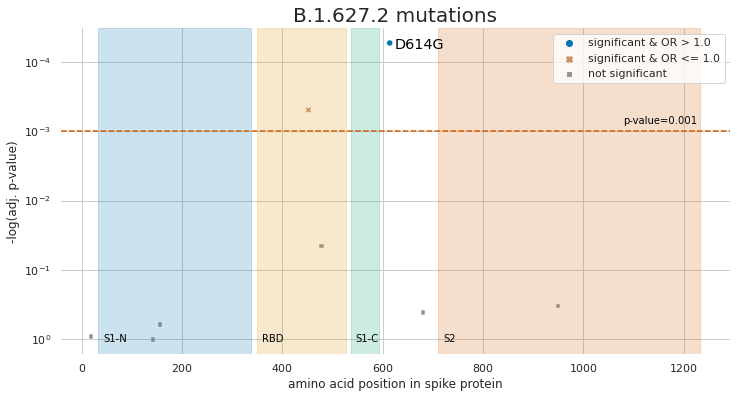

In [353]:
plot_enriched_mutations(
    data=delta_mutation_enrichment, 
    title="B.1.627.2 mutations",
    figname="figure_04_delta_enriched_mutations.png"
)

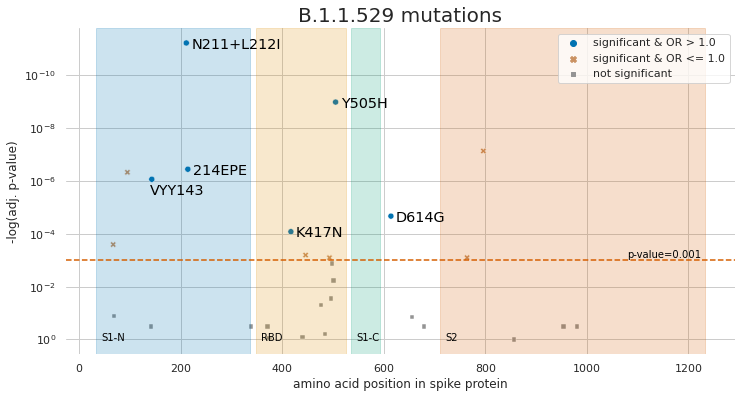

In [354]:
plot_enriched_mutations(
    data=omicron_mutation_enrichment,
    title="B.1.1.529 mutations",
    figname="figure_04_omicron_enriched_mutations.png",
    reposition=True
)   

In [355]:
omicron_mutation_enrichment

,mutation,pvalue,OR,a,b,c,d,adj_pvalue,significant,position,reference,alternate,identifier
0,N764K,3.253205e-04,0.181002,3,99,297,1774,8.007888e-04,significant & OR <= 1.0,764,N,K,N764K
1,L981F,2.610271e-01,0.660866,11,102,289,1771,3.230980e-01,not significant,981,L,F,L981F
2,E484A,5.490807e-01,0.781371,11,87,289,1786,6.275208e-01,not significant,484,E,A,E484A
3,Q493R,3.253205e-04,0.181002,3,99,297,1774,8.007888e-04,significant & OR <= 1.0,493,Q,R,Q493R
4,H655Y,8.824730e-02,0.548351,9,100,291,1773,1.411957e-01,not significant,655,H,Y,H655Y
5,N679K+P681H,2.726139e-01,1.226964,38,198,262,1675,3.230980e-01,not significant,679,N,K,N679K
7,T95I,8.840288e-08,0.108888,3,159,297,1714,4.714820e-07,significant & OR <= 1.0,95,T,I,T95I
8,G339D,2.645103e-01,0.639032,8,77,292,1796,3.230980e-01,not significant,339,G,D,G339D
9,A67V,7.972837e-05,0.000000,0,65,300,1808,2.551308e-04,significant & OR <= 1.0,67,A,V,A67V
10,N856K,1.000000e+00,0.000000,0,5,300,1868,1.000000e+00,not significant,856,N,K,N856K


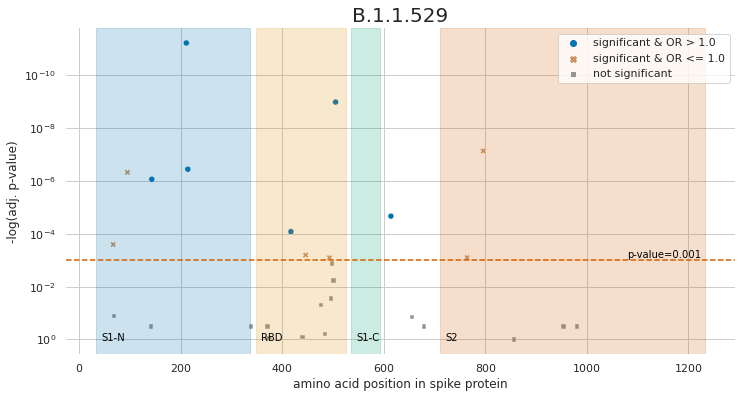

In [356]:
plot_enriched_mutations(
    data=omicron_mutation_enrichment, 
    annotations=False,
    title="B.1.1.529",
    figname="figure_04_omicron_enriched_mutations_wo_annotations.png"
)   